3個變量的VAR(9)模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import kpss, adfuller, ccf, ccovf
from statsmodels.iolib.smpickle import load_pickle
from Diebold_Mariano_Test.dm_test import dm_test

In [2]:
horizon = pd.read_csv(".\\data\\horizon_3multivariate_final.csv", encoding="utf-8")
horizon_diff = horizon.diff().dropna()
horizon.head()

CPU Overall Power Consumption  GPU Power  FPS
0                         99.895    305.353  113
1                        104.135    341.418  146
2                        107.012    345.209  147
3                        105.918    342.610  150
4                        103.853    345.456  152

## VAR DIFF

In [3]:
horizon_diff_train = horizon_diff[:-300] # (2892, 3)
horizon_diff_test = horizon_diff[-300:] # (300, 3)
fps = horizon["FPS"].to_numpy()
fps_diff = horizon_diff["FPS"]

In [4]:
var = VAR(horizon_diff_train)
var_order_result = var.select_order(12)

e:\Master\Time Series\TimeSeries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [5]:
var_order_result.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [6]:
# ic_table = pd.DataFrame(var_order_result.summary()).set_index(0).iloc[1:].reset_index(drop=True)
ic_table = pd.read_html(var_order_result.summary().as_html(), header=0, index_col=0)

In [7]:
ic_table[0] = ic_table[0].replace("\*$", "", regex=True)
ic_table[0] = ic_table[0].astype("float64")

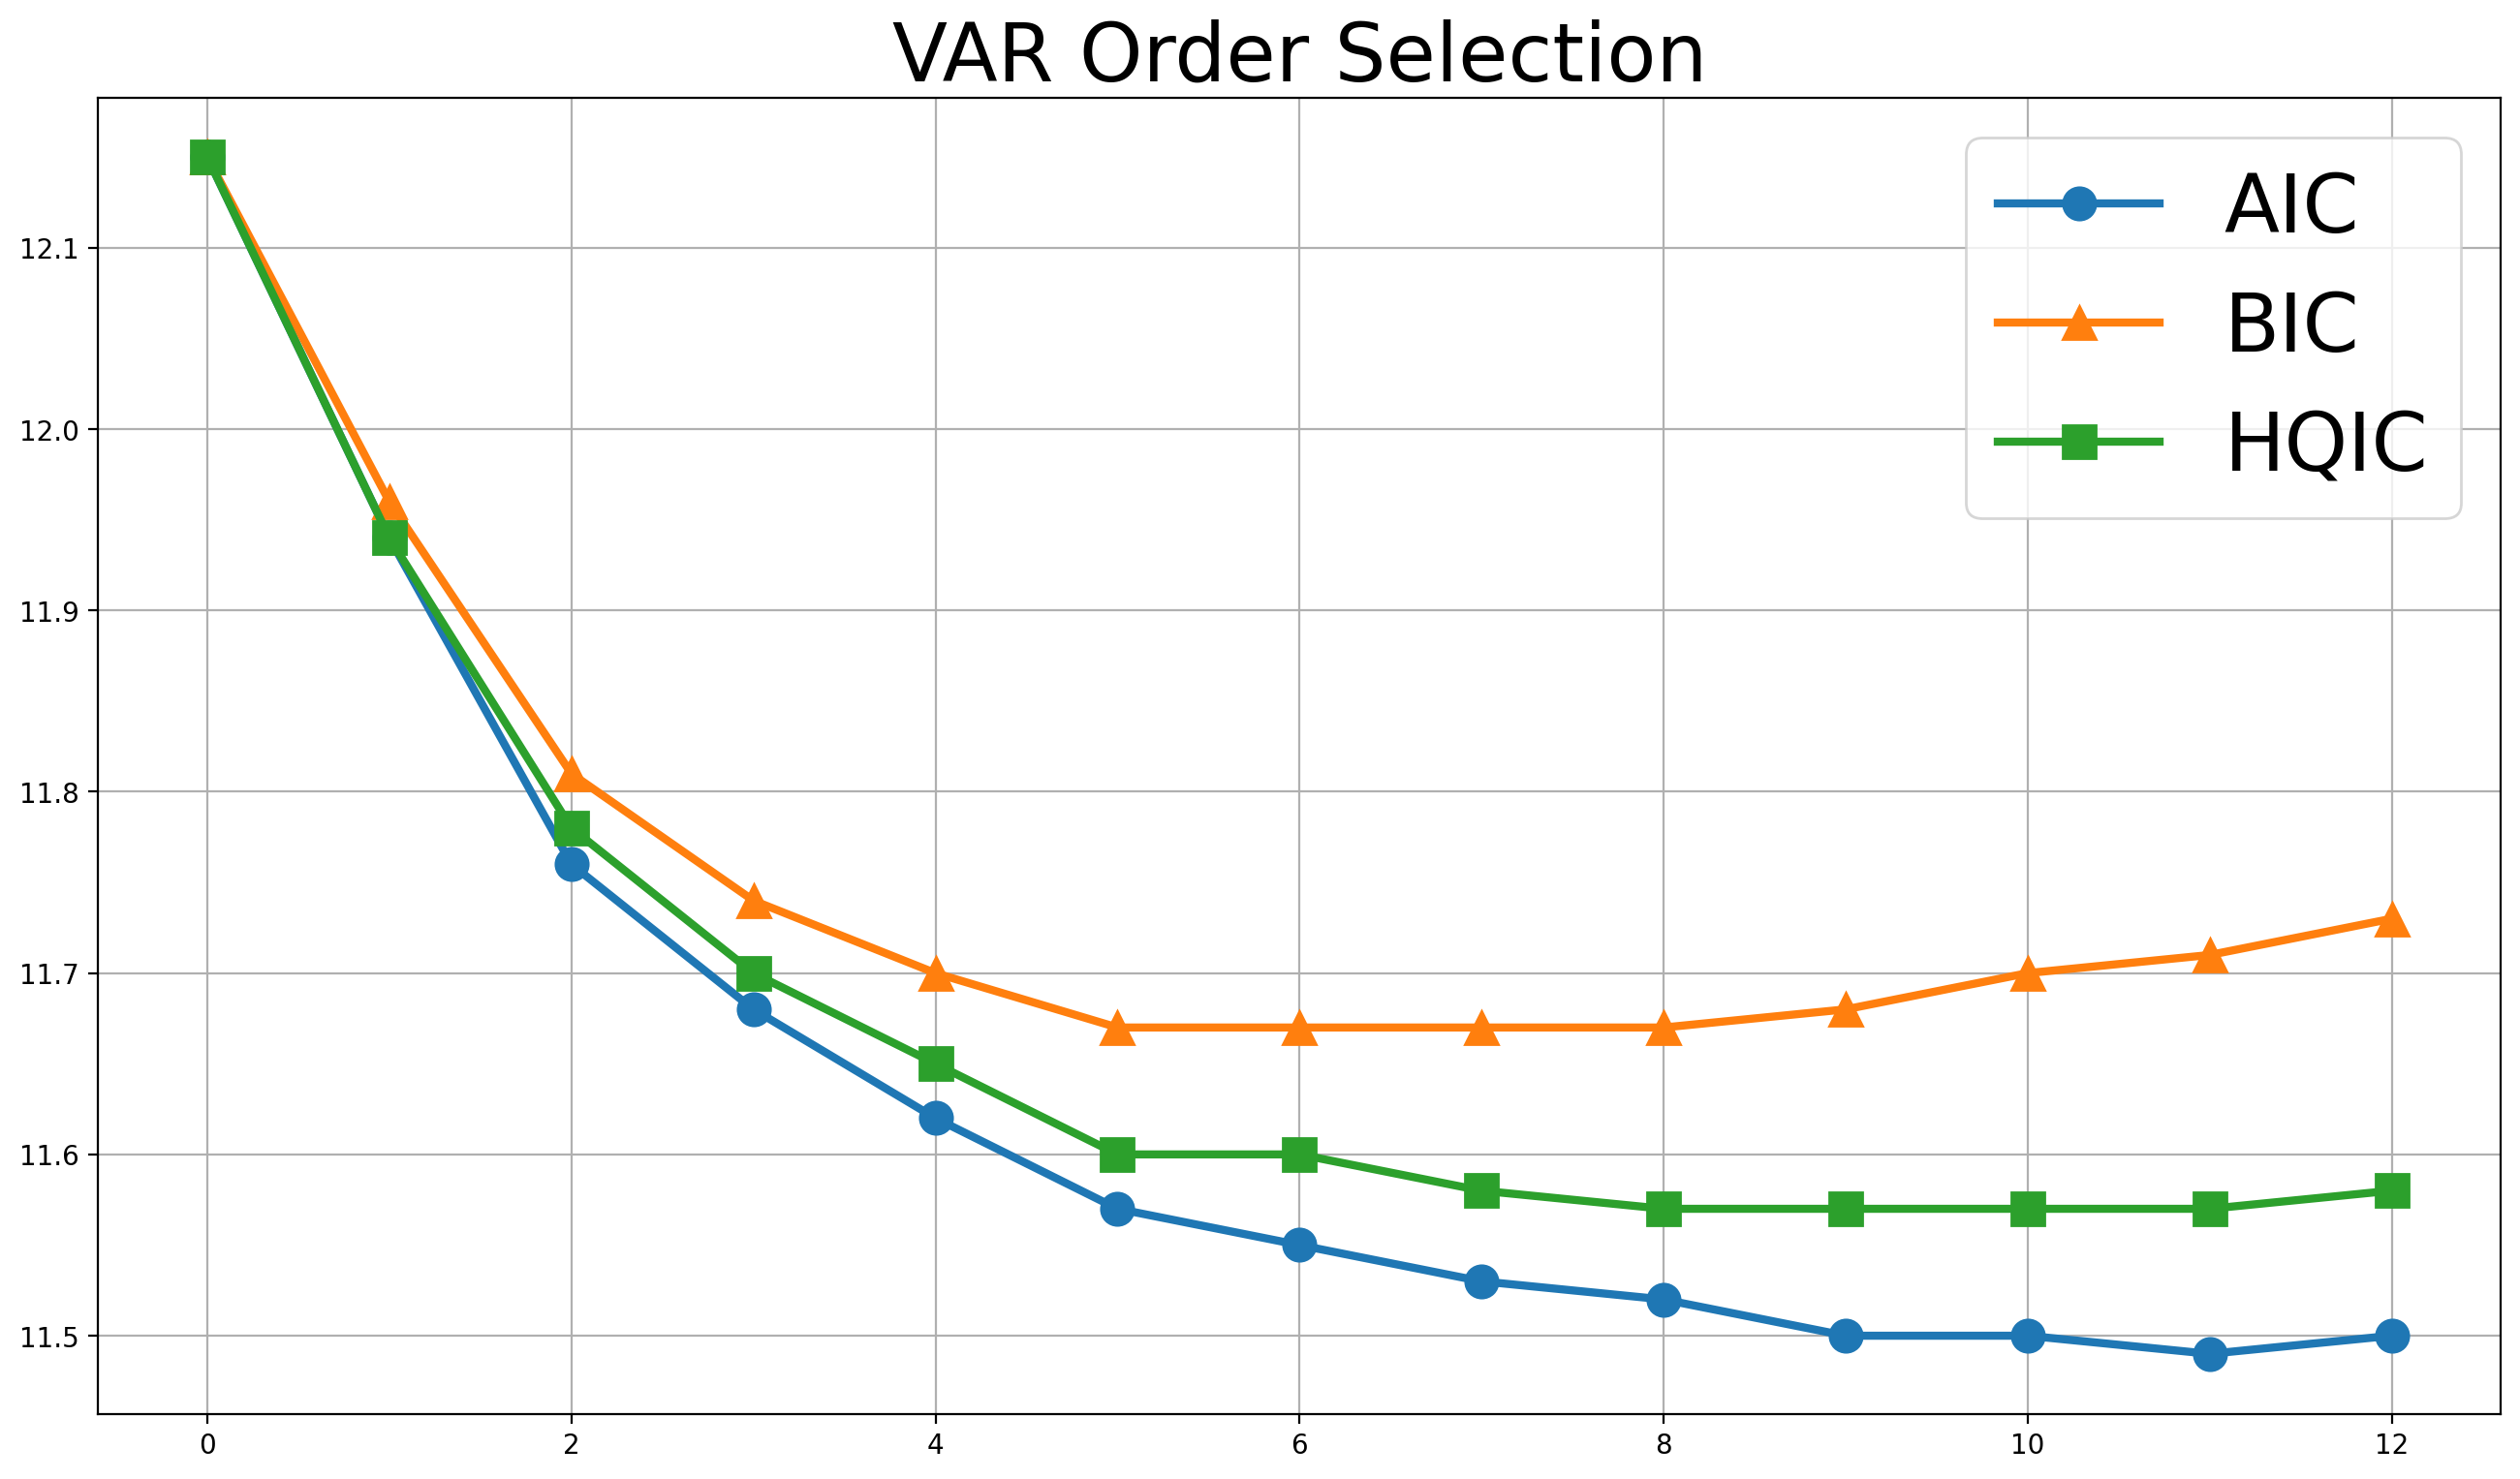

In [8]:
plt.figure(figsize=(16,9), dpi=200)
aic, = plt.plot(ic_table[0]["AIC"], "-o", linewidth=3, ms=12, label="AIC")
bic, = plt.plot(ic_table[0]["BIC"], "-^", linewidth=3, ms=12, label="BIC")
hqic, = plt.plot(ic_table[0]["HQIC"], "-s", linewidth=3, ms=12, label="HQIC")
plt.legend(handles=[aic, bic, hqic], fontsize=30)
plt.title("VAR Order Selection", fontdict={'fontsize':30})
plt.grid()
plt.show()

In [9]:
var_result = var.fit(9)

In [10]:
var_result.llf

-28774.021621239375

In [11]:
var_result.info_criteria

{'aic': 11.505808010788874,
 'bic': 11.679652368264291,
 'hqic': 11.568466016415176,
 'fpe': 99290.96342085353}

In [12]:
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Jun, 2022
Time:                     23:33:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.6797
Nobs:                     2883.00    HQIC:                   11.5685
Log likelihood:          -28774.0    FPE:                    99291.0
AIC:                      11.5058    Det(Omega_mle):         96453.3
--------------------------------------------------------------------
Results for equation CPU Overall Power Consumption
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                    0.029161         0.058523            0.498           0.618
L1.CPU Overall Power Consumption        -0.435245         0.

In [13]:
irf_var = var_result.irf()

In [14]:
irf_var.G[0].shape

(9, 81)

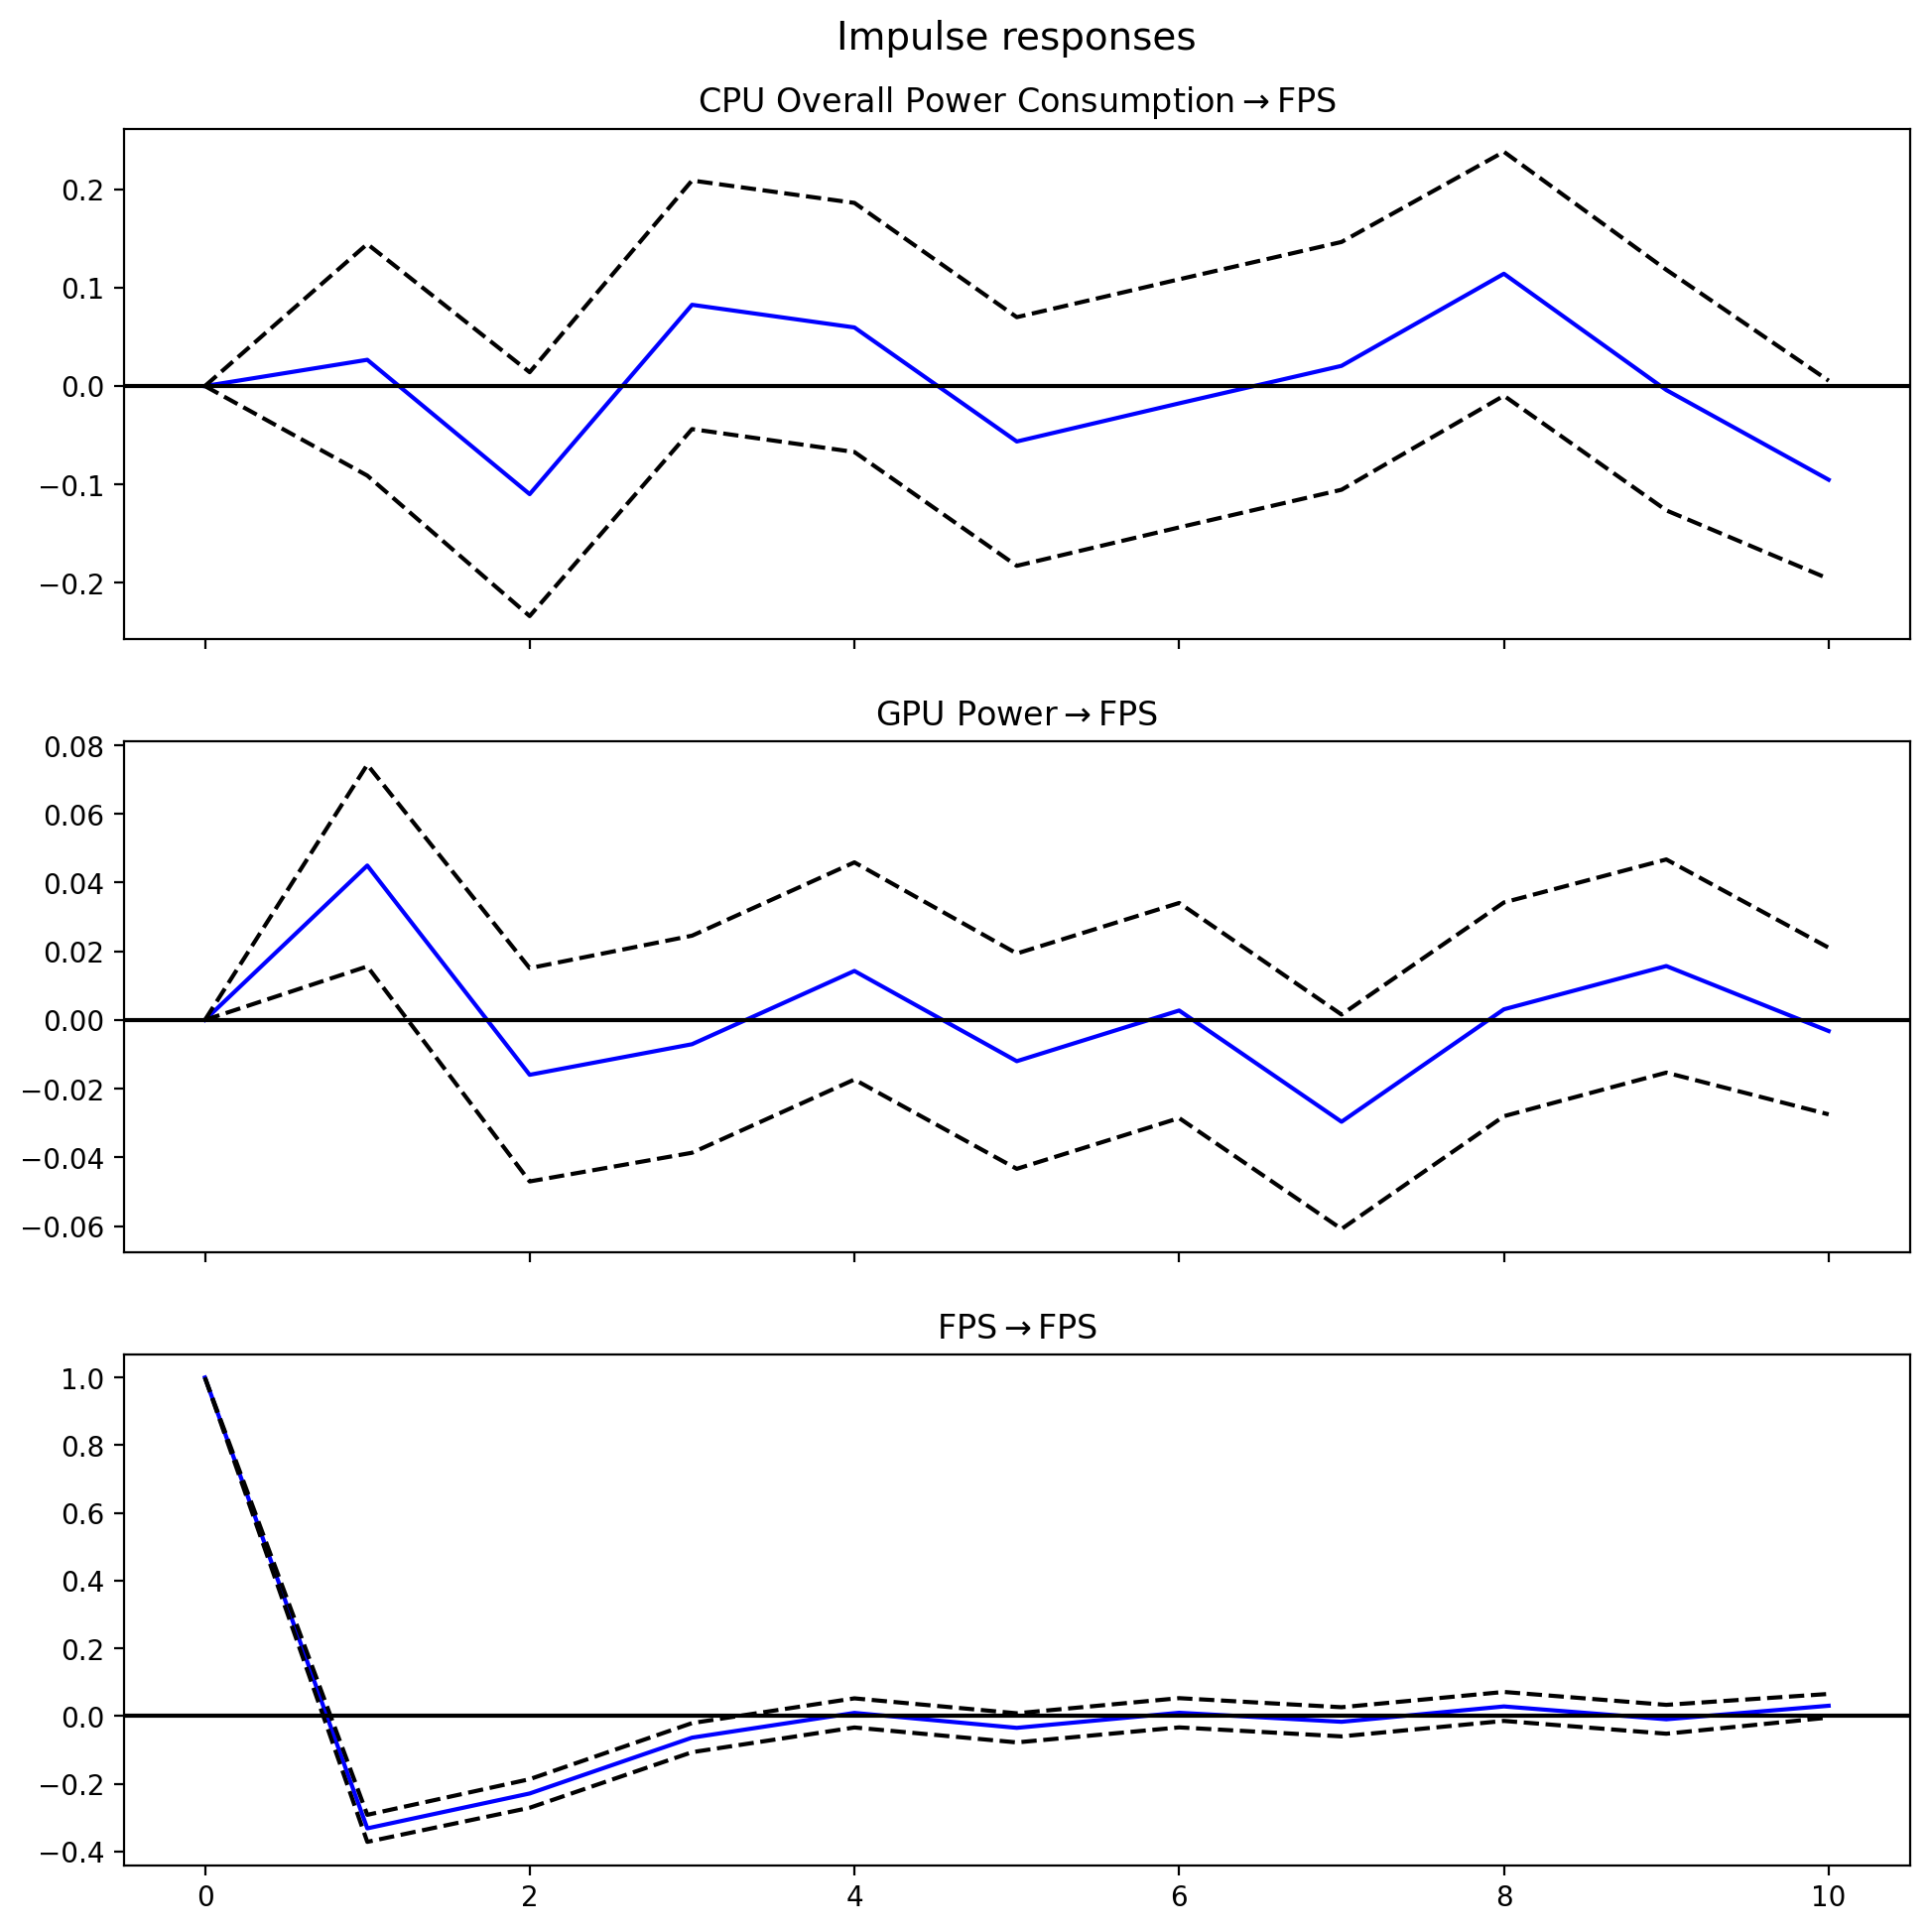

In [15]:
irf_var.plot(response="FPS")
plt.show()

In [16]:
var_result.test_whiteness().summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [17]:
var_result.test_normality().summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [18]:
var_result.test_causality(
    "FPS",
    ["CPU Overall Power Consumption", "GPU Power"],
    kind='f'
).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

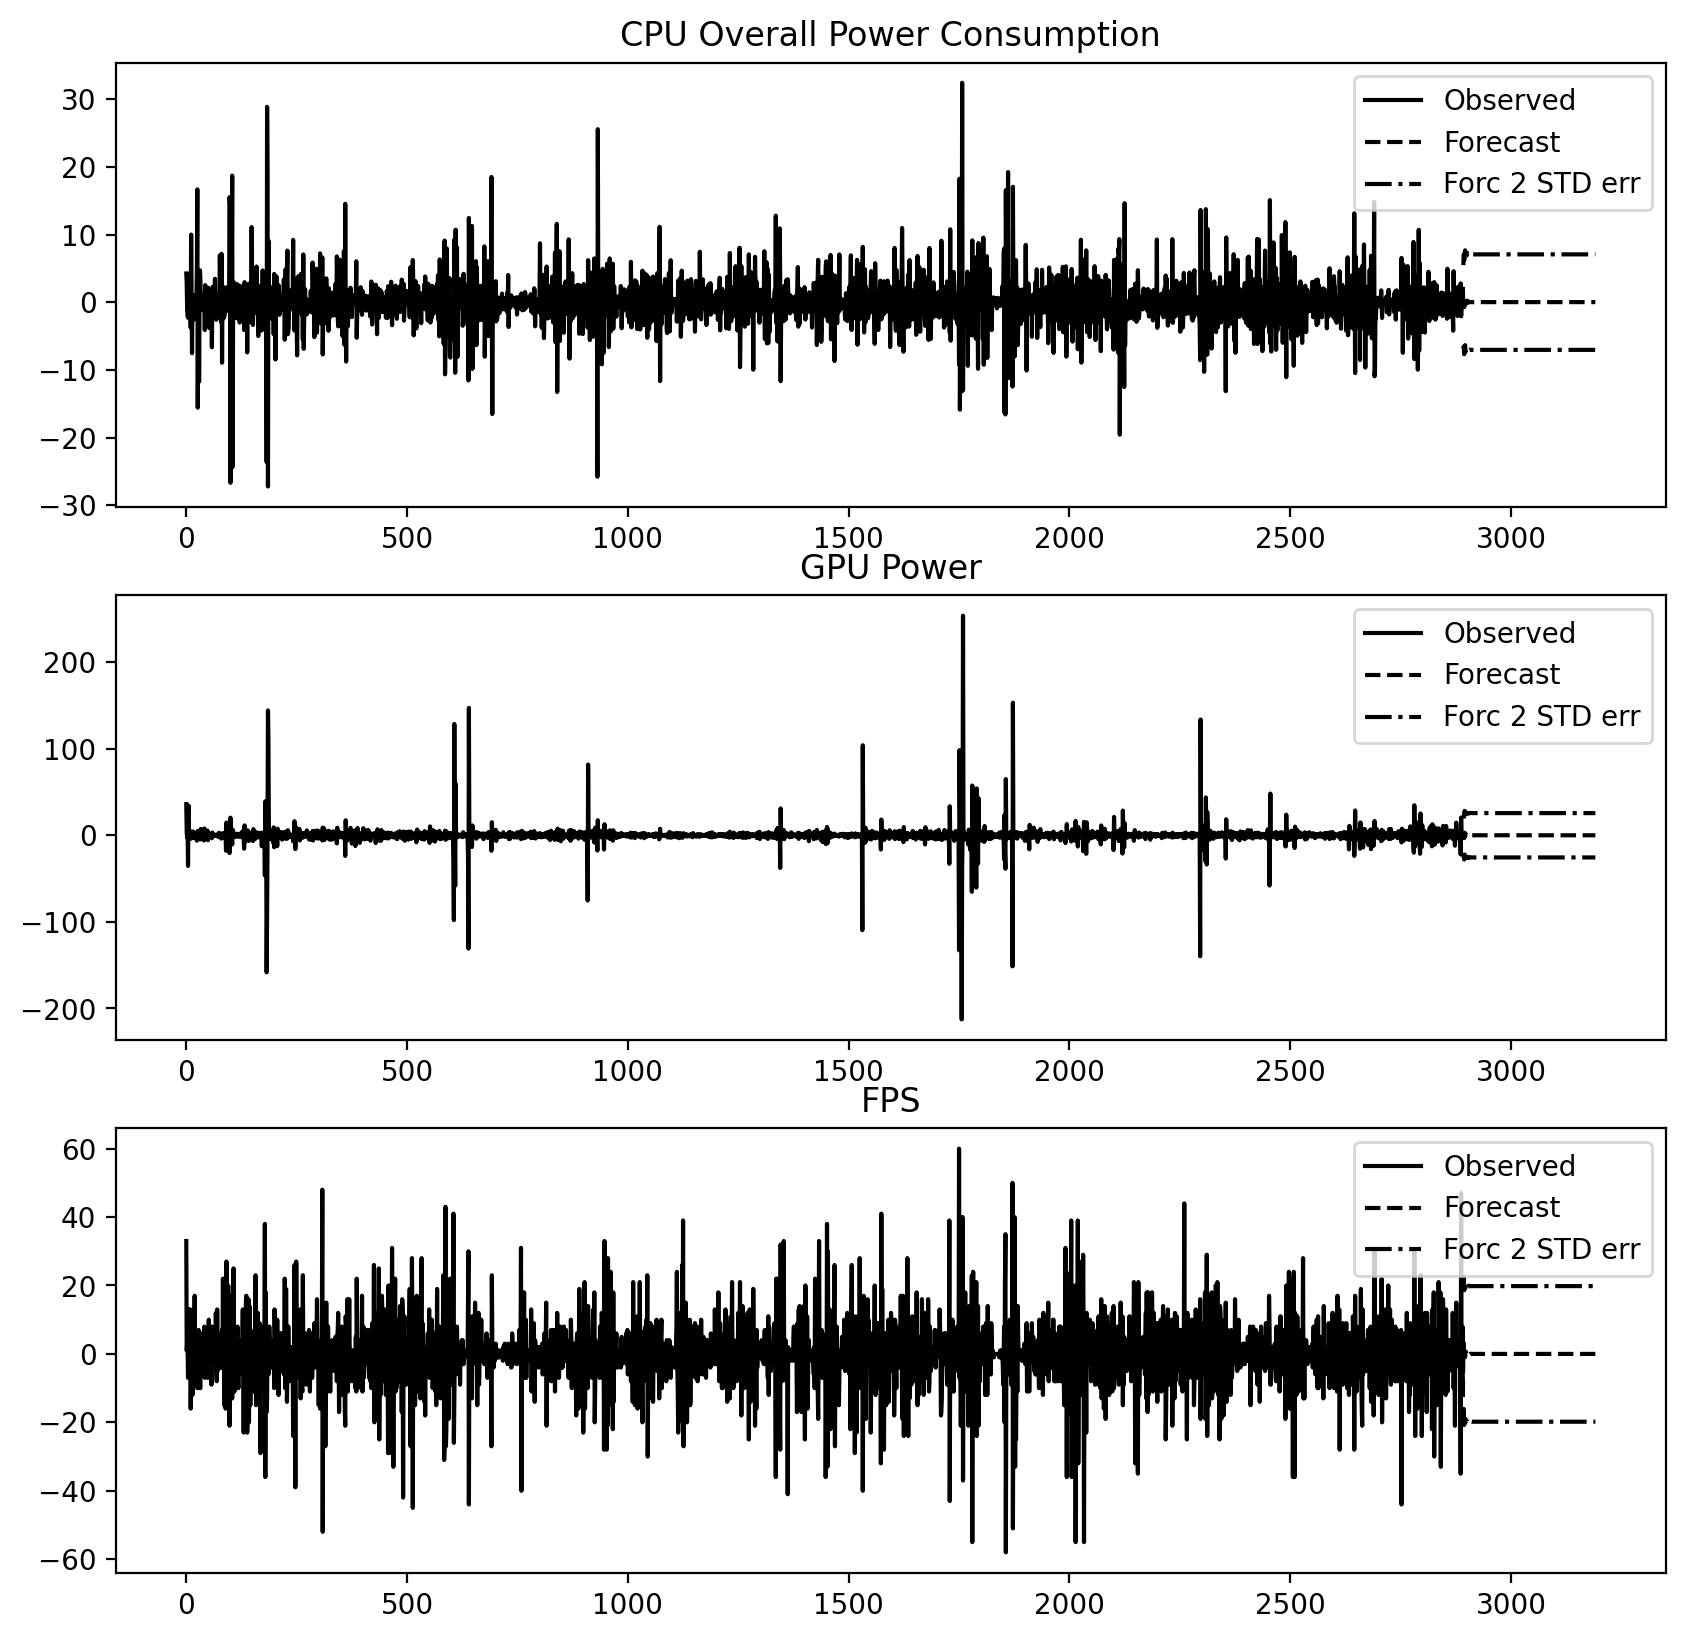

In [19]:
fig = var_result.plot_forecast(steps=300)
fig.dpi = 200
plt.show()

In [20]:
fevd = var_result.fevd()
fevd.summary()

FEVD for CPU Overall Power Consumption
     CPU Overall Power Consumption  GPU Power       FPS
0                         1.000000   0.000000  0.000000
1                         0.935262   0.033259  0.031479
2                         0.933717   0.034311  0.031972
3                         0.923254   0.039411  0.037336
4                         0.922302   0.039383  0.038315
5                         0.922091   0.039599  0.038310
6                         0.920228   0.039800  0.039972
7                         0.919397   0.040687  0.039916
8                         0.917856   0.041814  0.040330
9                         0.916899   0.042845  0.040257

FEVD for GPU Power
     CPU Overall Power Consumption  GPU Power       FPS
0                         0.008086   0.991914  0.000000
1                         0.009290   0.988340  0.002370
2                         0.013215   0.983455  0.003330
3                         0.016756   0.978870  0.004374
4                         0.016924   0.975460

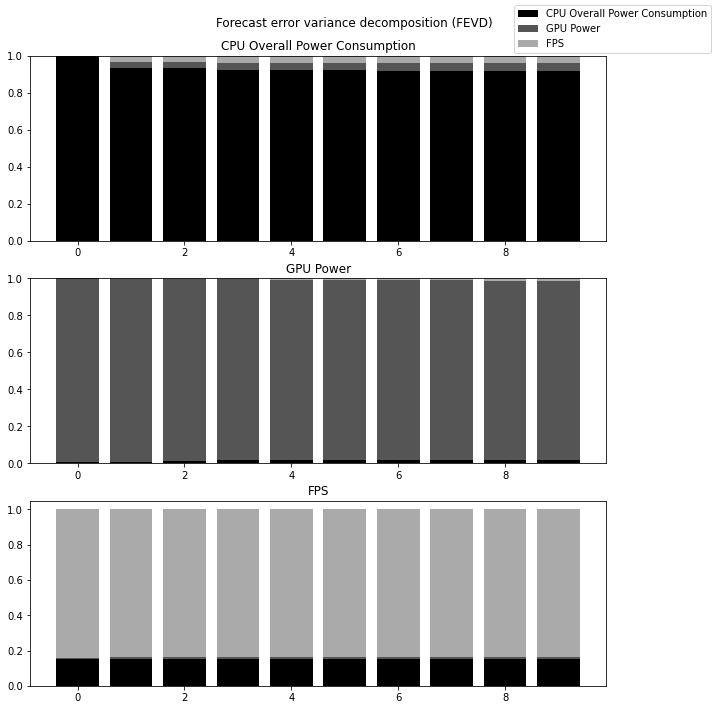

In [21]:
fevd.plot()
plt.show()

In [22]:
var_result.resid_acorr(nlags=0).reshape((3,3))

array([[ 1.        ,  0.0899204 , -0.38861237],
       [ 0.0899204 ,  1.        , -0.11429984],
       [-0.38861237, -0.11429984,  1.        ]])

### VARMAX DIFF

In [23]:
# varmax90 = VARMAX(horizon_diff_train, order=(9, 0))
# varmax90_result = varmax90.fit()
varmax90_result = load_pickle(".\\weights\\VARMA DIFF 3\\VARMA_result_90.pickle")

In [24]:
# varmax90_result.summary()

In [25]:
varmax90_result.llf

-28881.45182356593

In [26]:
varmax90_result.impulse_responses(impulse=2, orthogonalized=False, steps=10)

CPU Overall Power Consumption  GPU Power       FPS
0                        0.000000   0.000000  1.000000
1                       -0.070723   0.067419 -0.332093
2                        0.017767   0.047185 -0.228028
3                        0.031123  -0.048154 -0.063276
4                       -0.013267  -0.088538  0.008143
5                       -0.000104  -0.030899 -0.033370
6                        0.017178  -0.047040  0.011021
7                        0.000581   0.005511 -0.019122
8                        0.009648   0.091300  0.028479
9                       -0.000478   0.054991 -0.008721
10                      -0.014509  -0.021679  0.030113

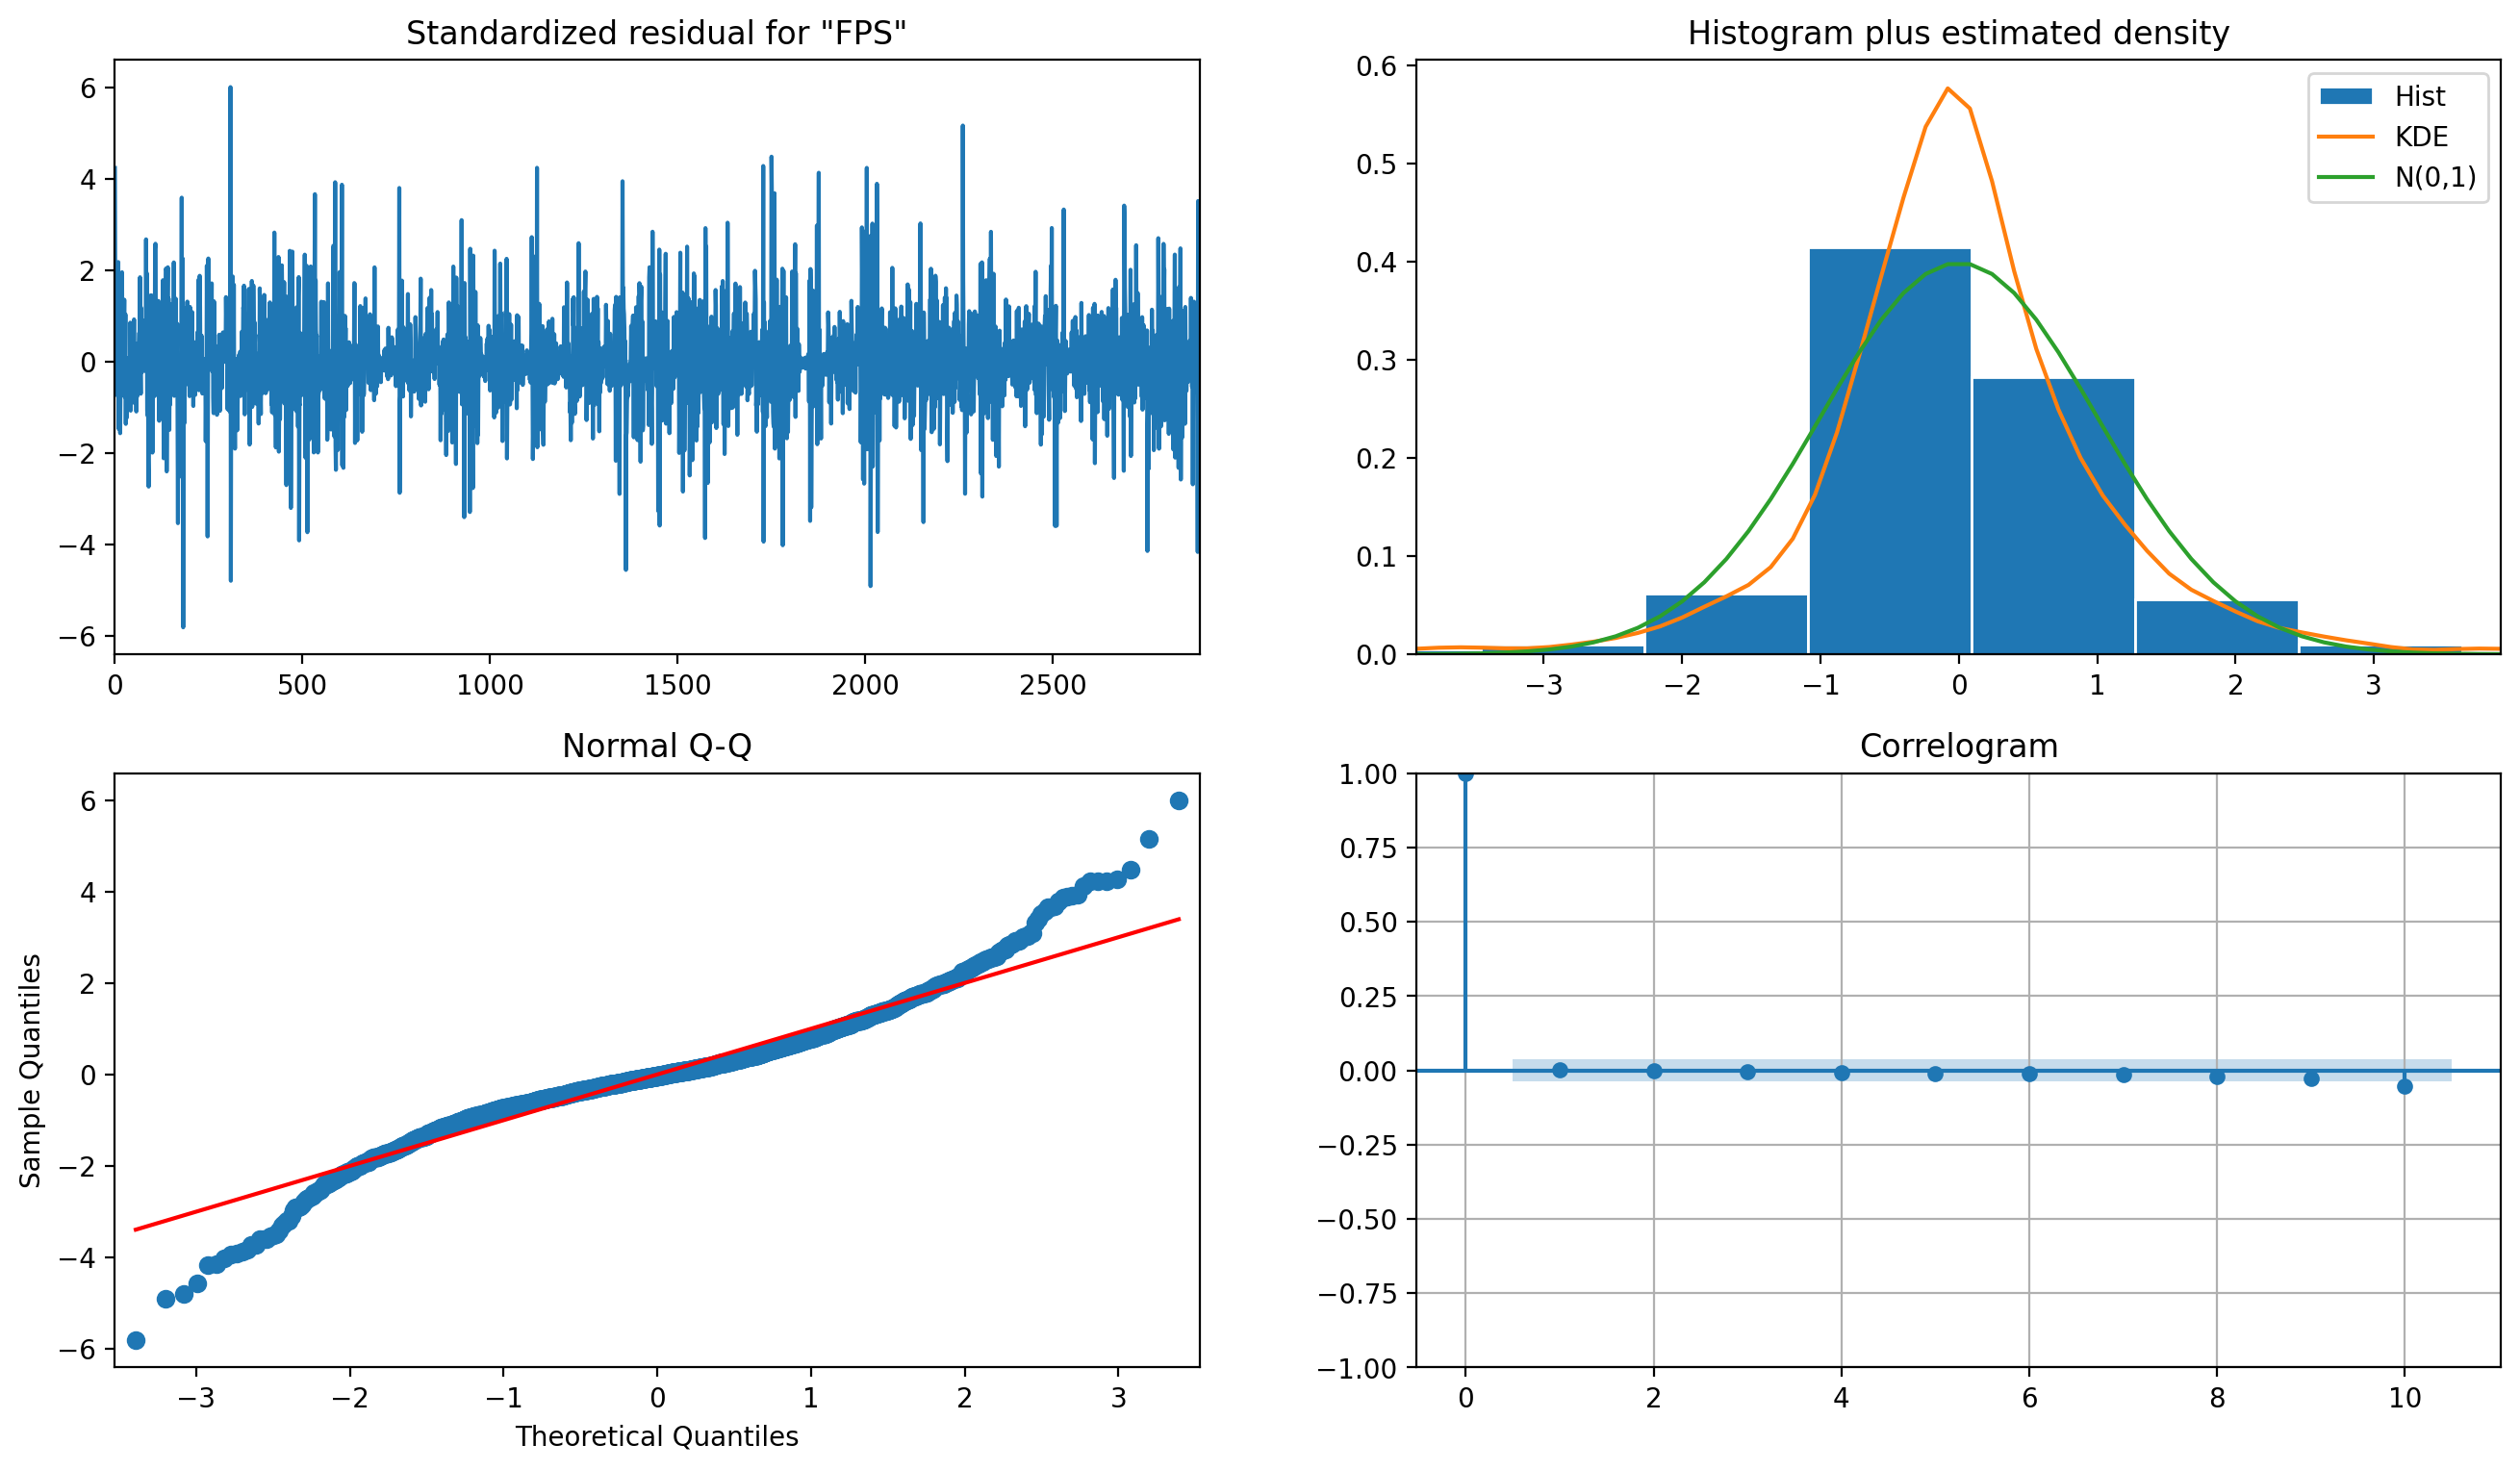

In [27]:
varmax90_result.plot_diagnostics(variable=2, fig=plt.figure(figsize=(16,9), dpi=200))
plt.grid()
plt.show()

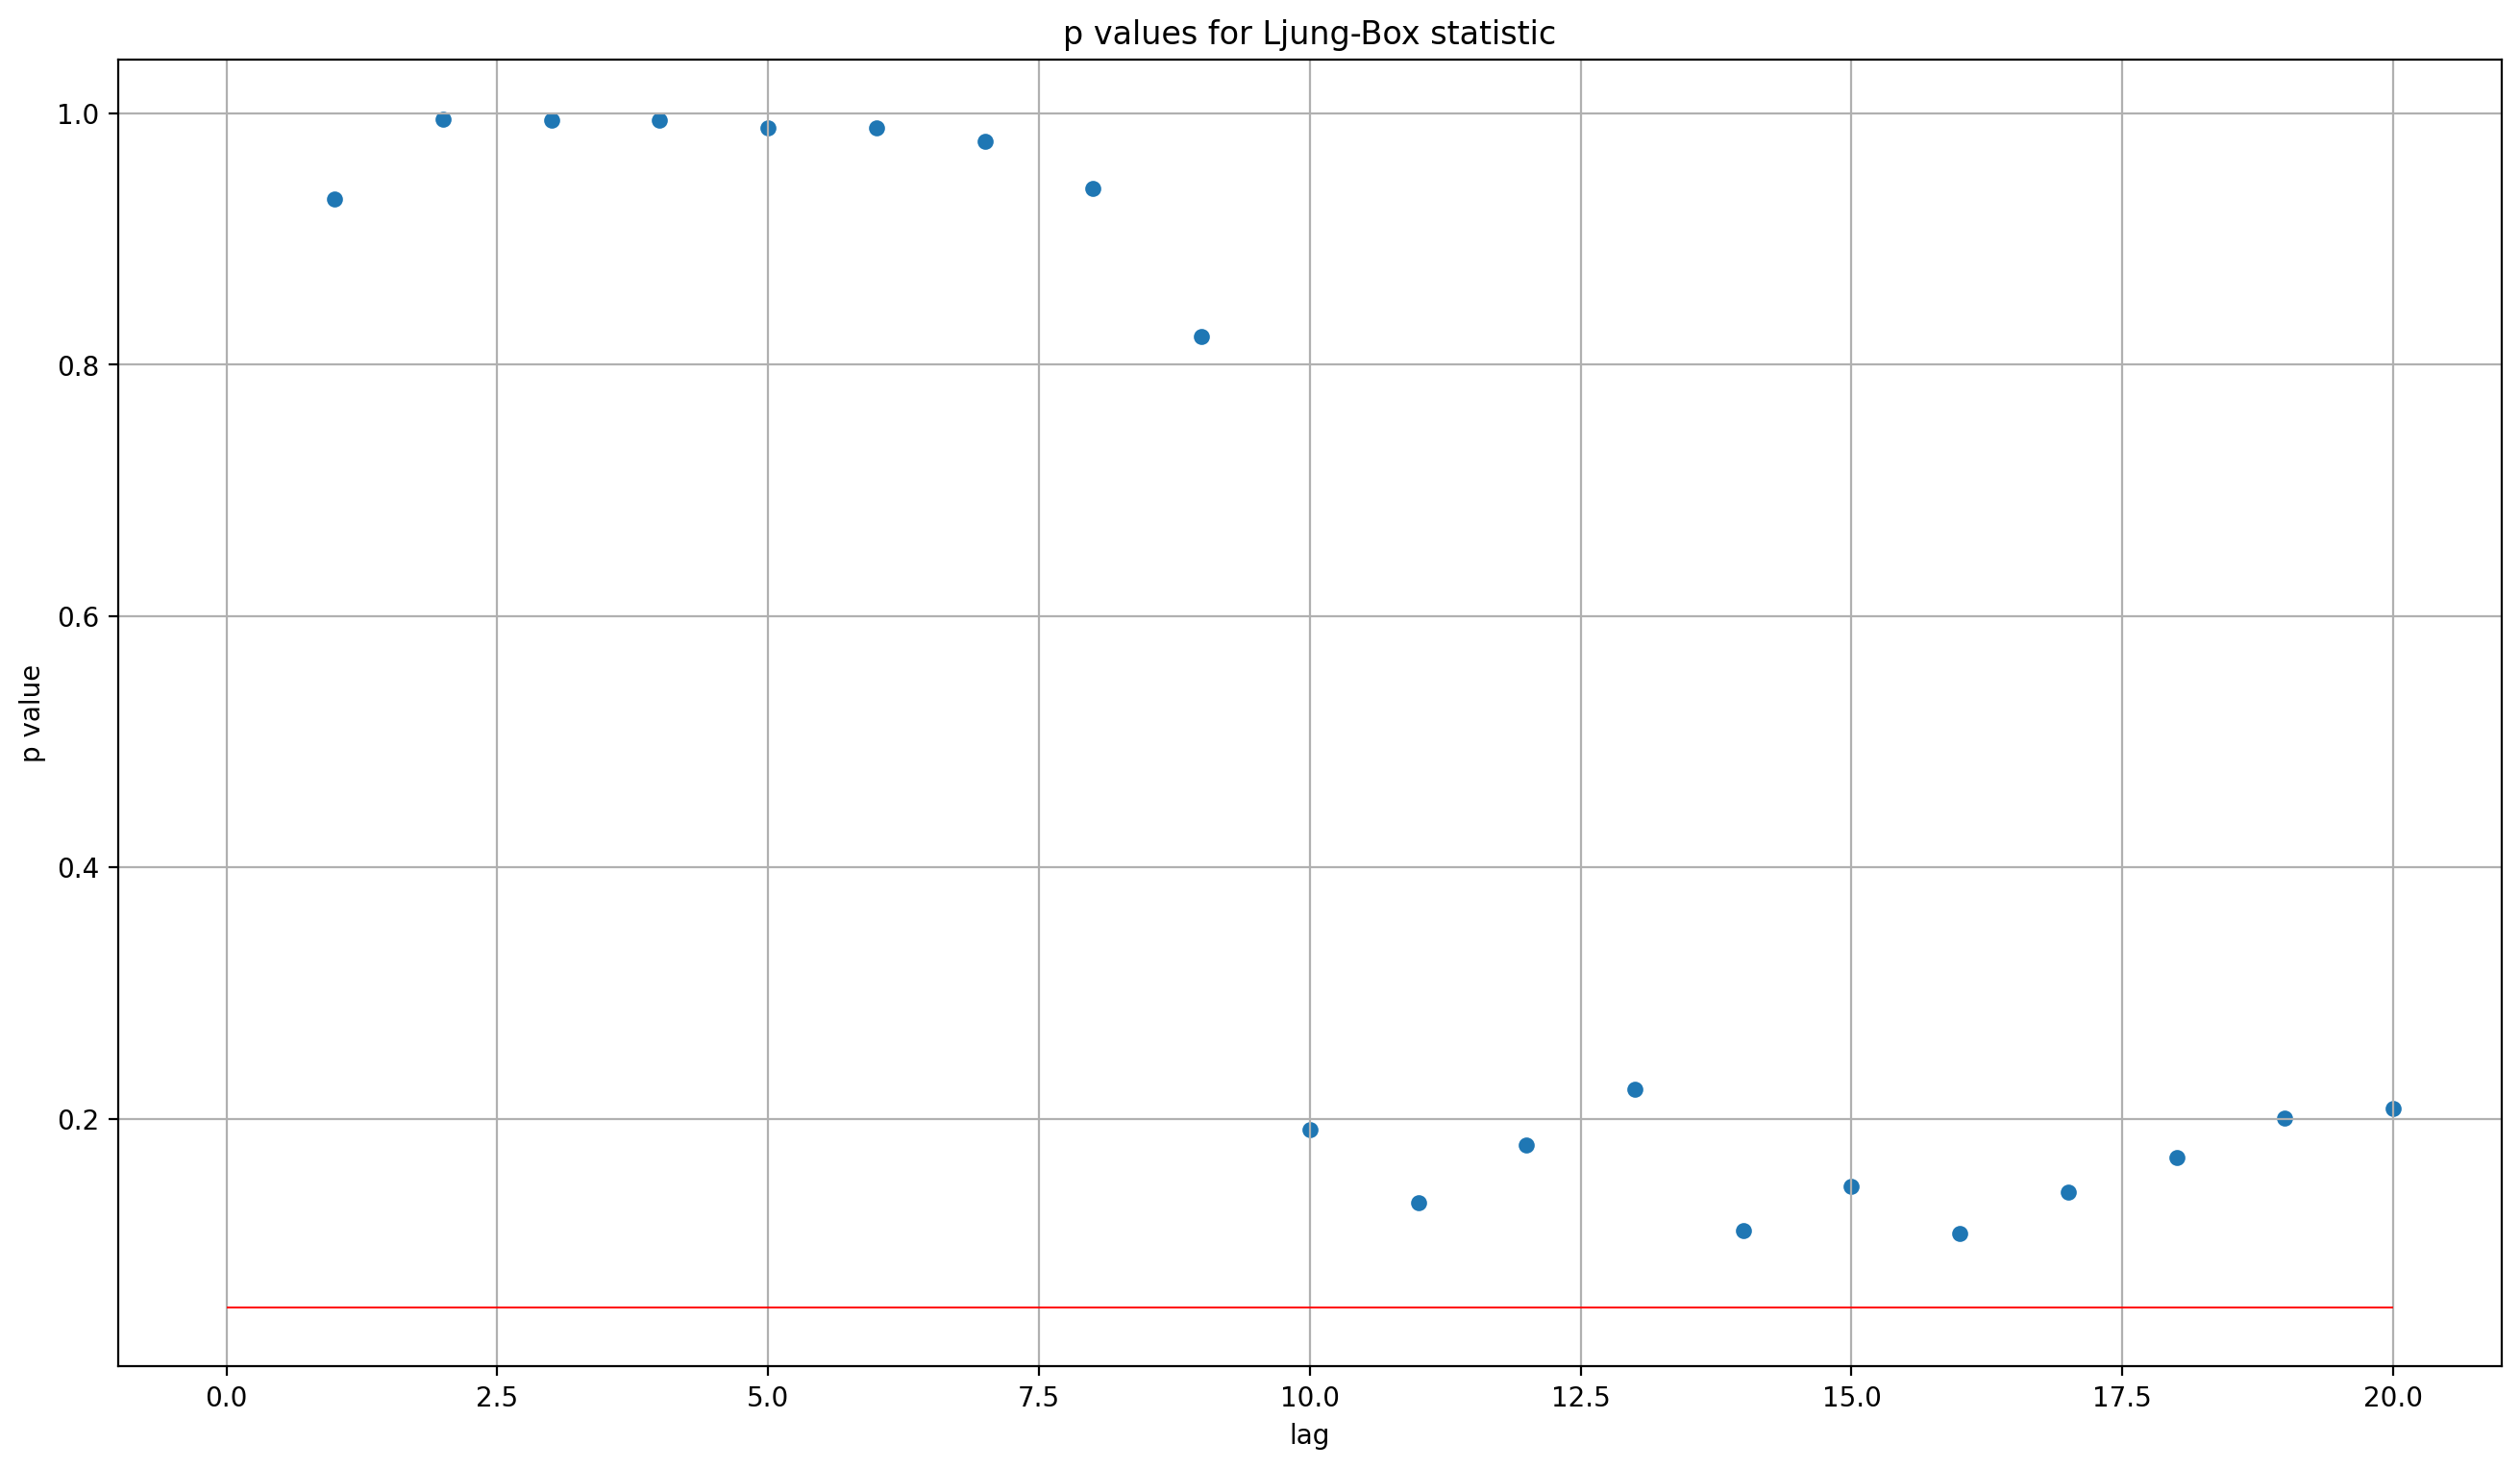

In [28]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(list(range(1,21)), varmax90_result.test_serial_correlation(method="ljungbox", lags=20)[2, 1, :], s=25)
plt.hlines(y=[0.05], xmin=0, xmax=20, colors="r", linewidths=0.7)
plt.title("p values for Ljung-Box statistic")
plt.xlabel("lag")
plt.ylabel("p value")
plt.grid()
plt.show()

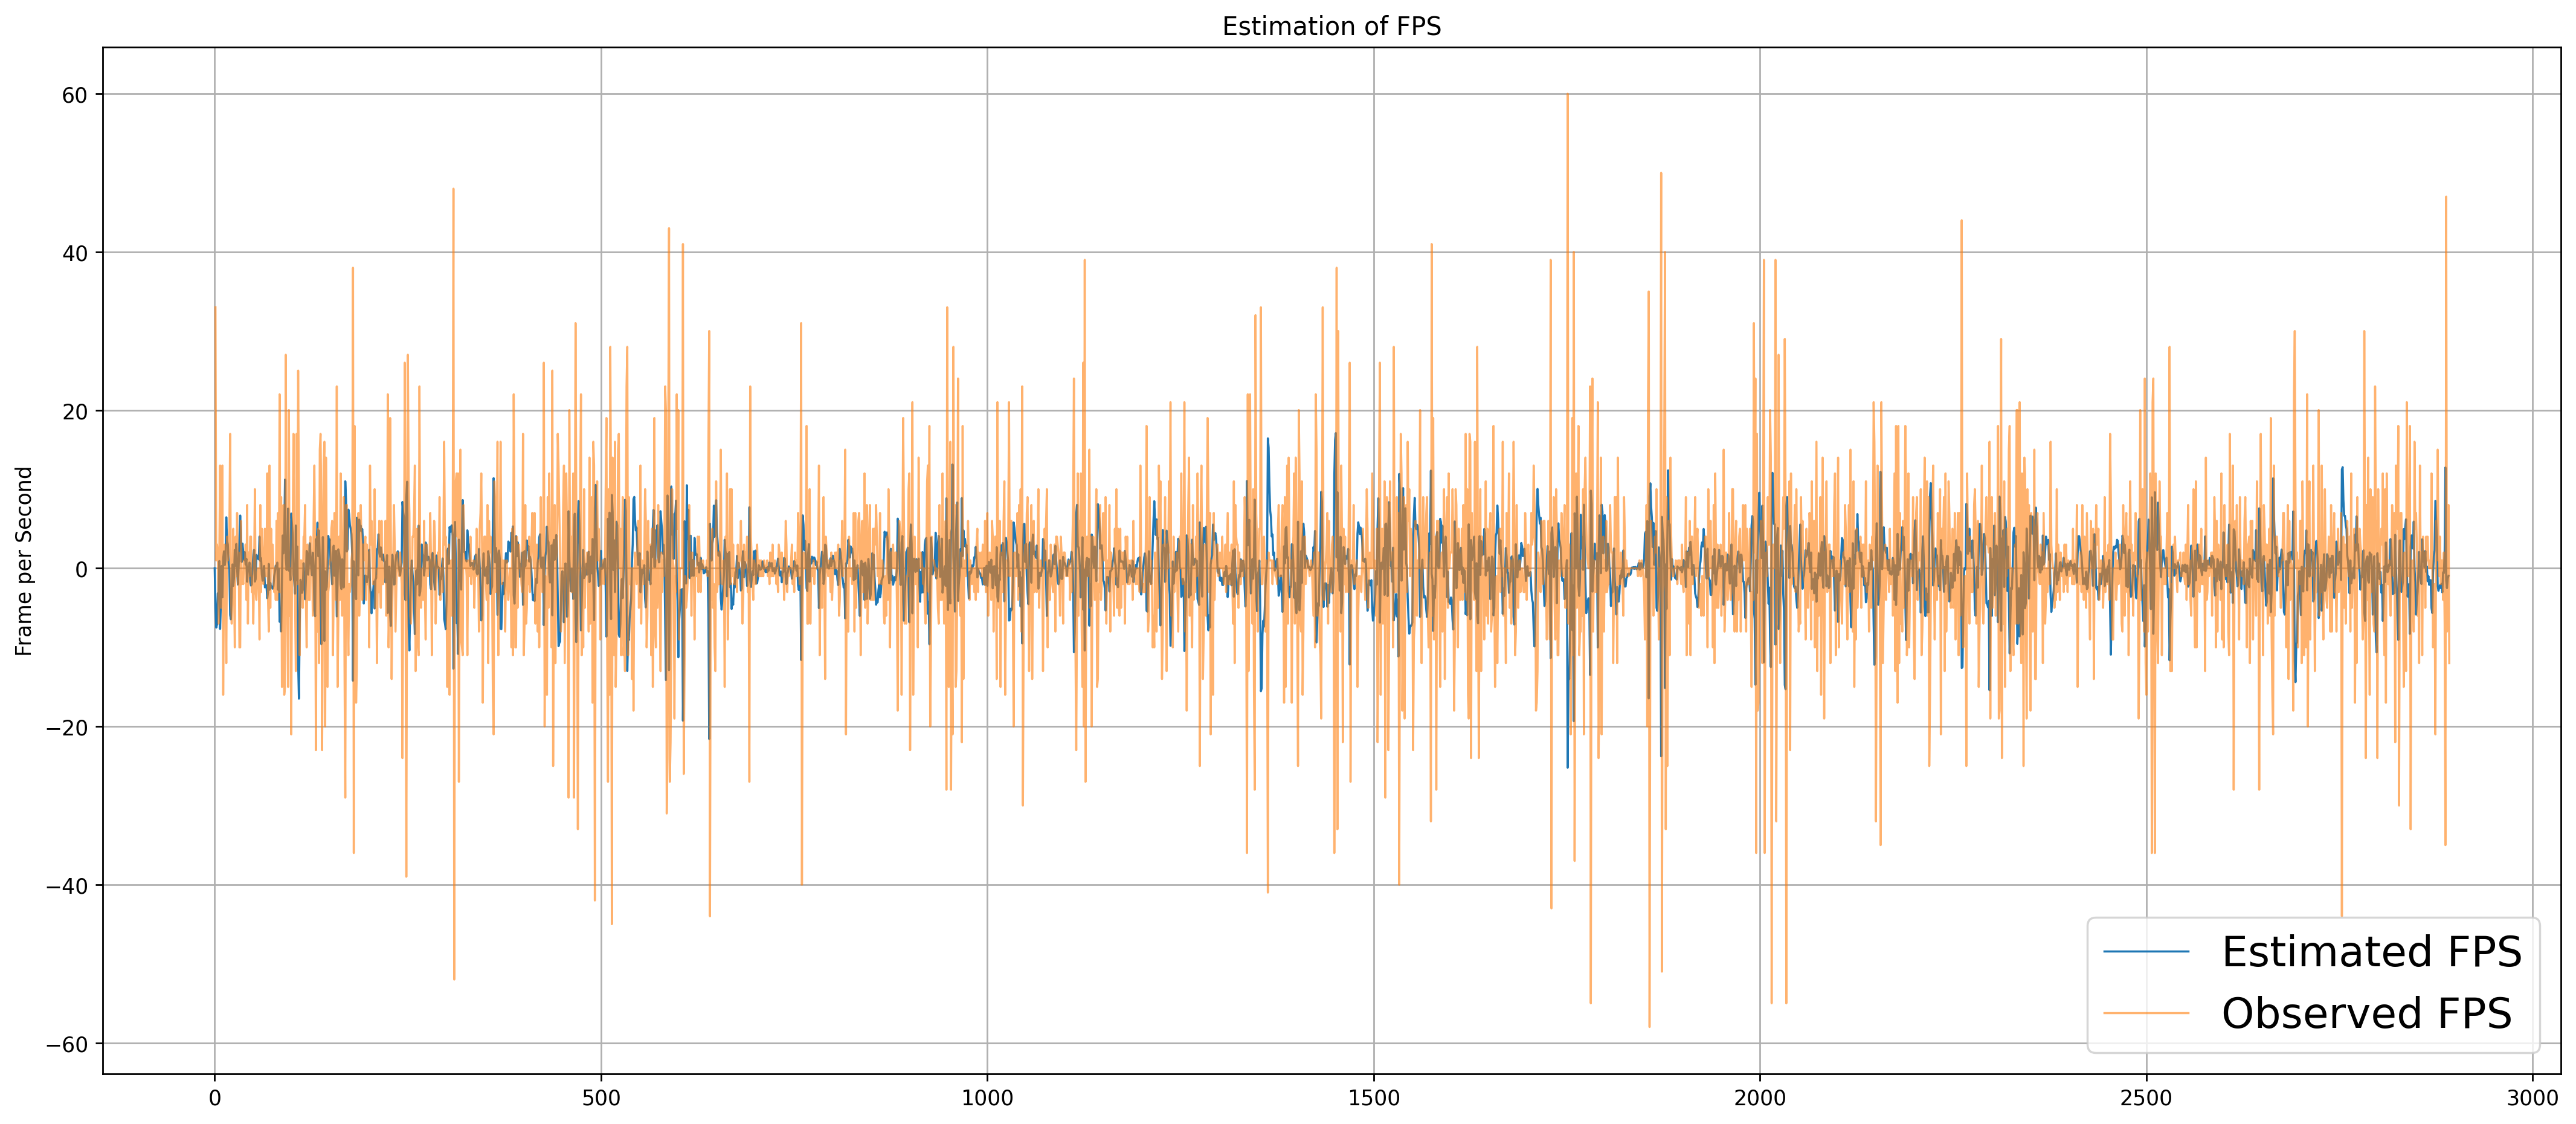

In [29]:
hat_FPS = varmax90_result.predict().to_numpy()[:, 2]
plt.figure(figsize=(21, 9), dpi=250)
ts1, = plt.plot(hat_FPS, linewidth=1, label="Estimated FPS", c='tab:blue')
ts2, = plt.plot(horizon_diff_train["FPS"], linewidth=1, label="Observed FPS", c='tab:orange', alpha=0.6)
plt.legend(handles=[ts1, ts2], fontsize=20)
plt.title("Estimation of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()

In [30]:
varmax_forecasting = varmax90_result.get_forecast(steps=300)

e:\Master\Time Series\TimeSeries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


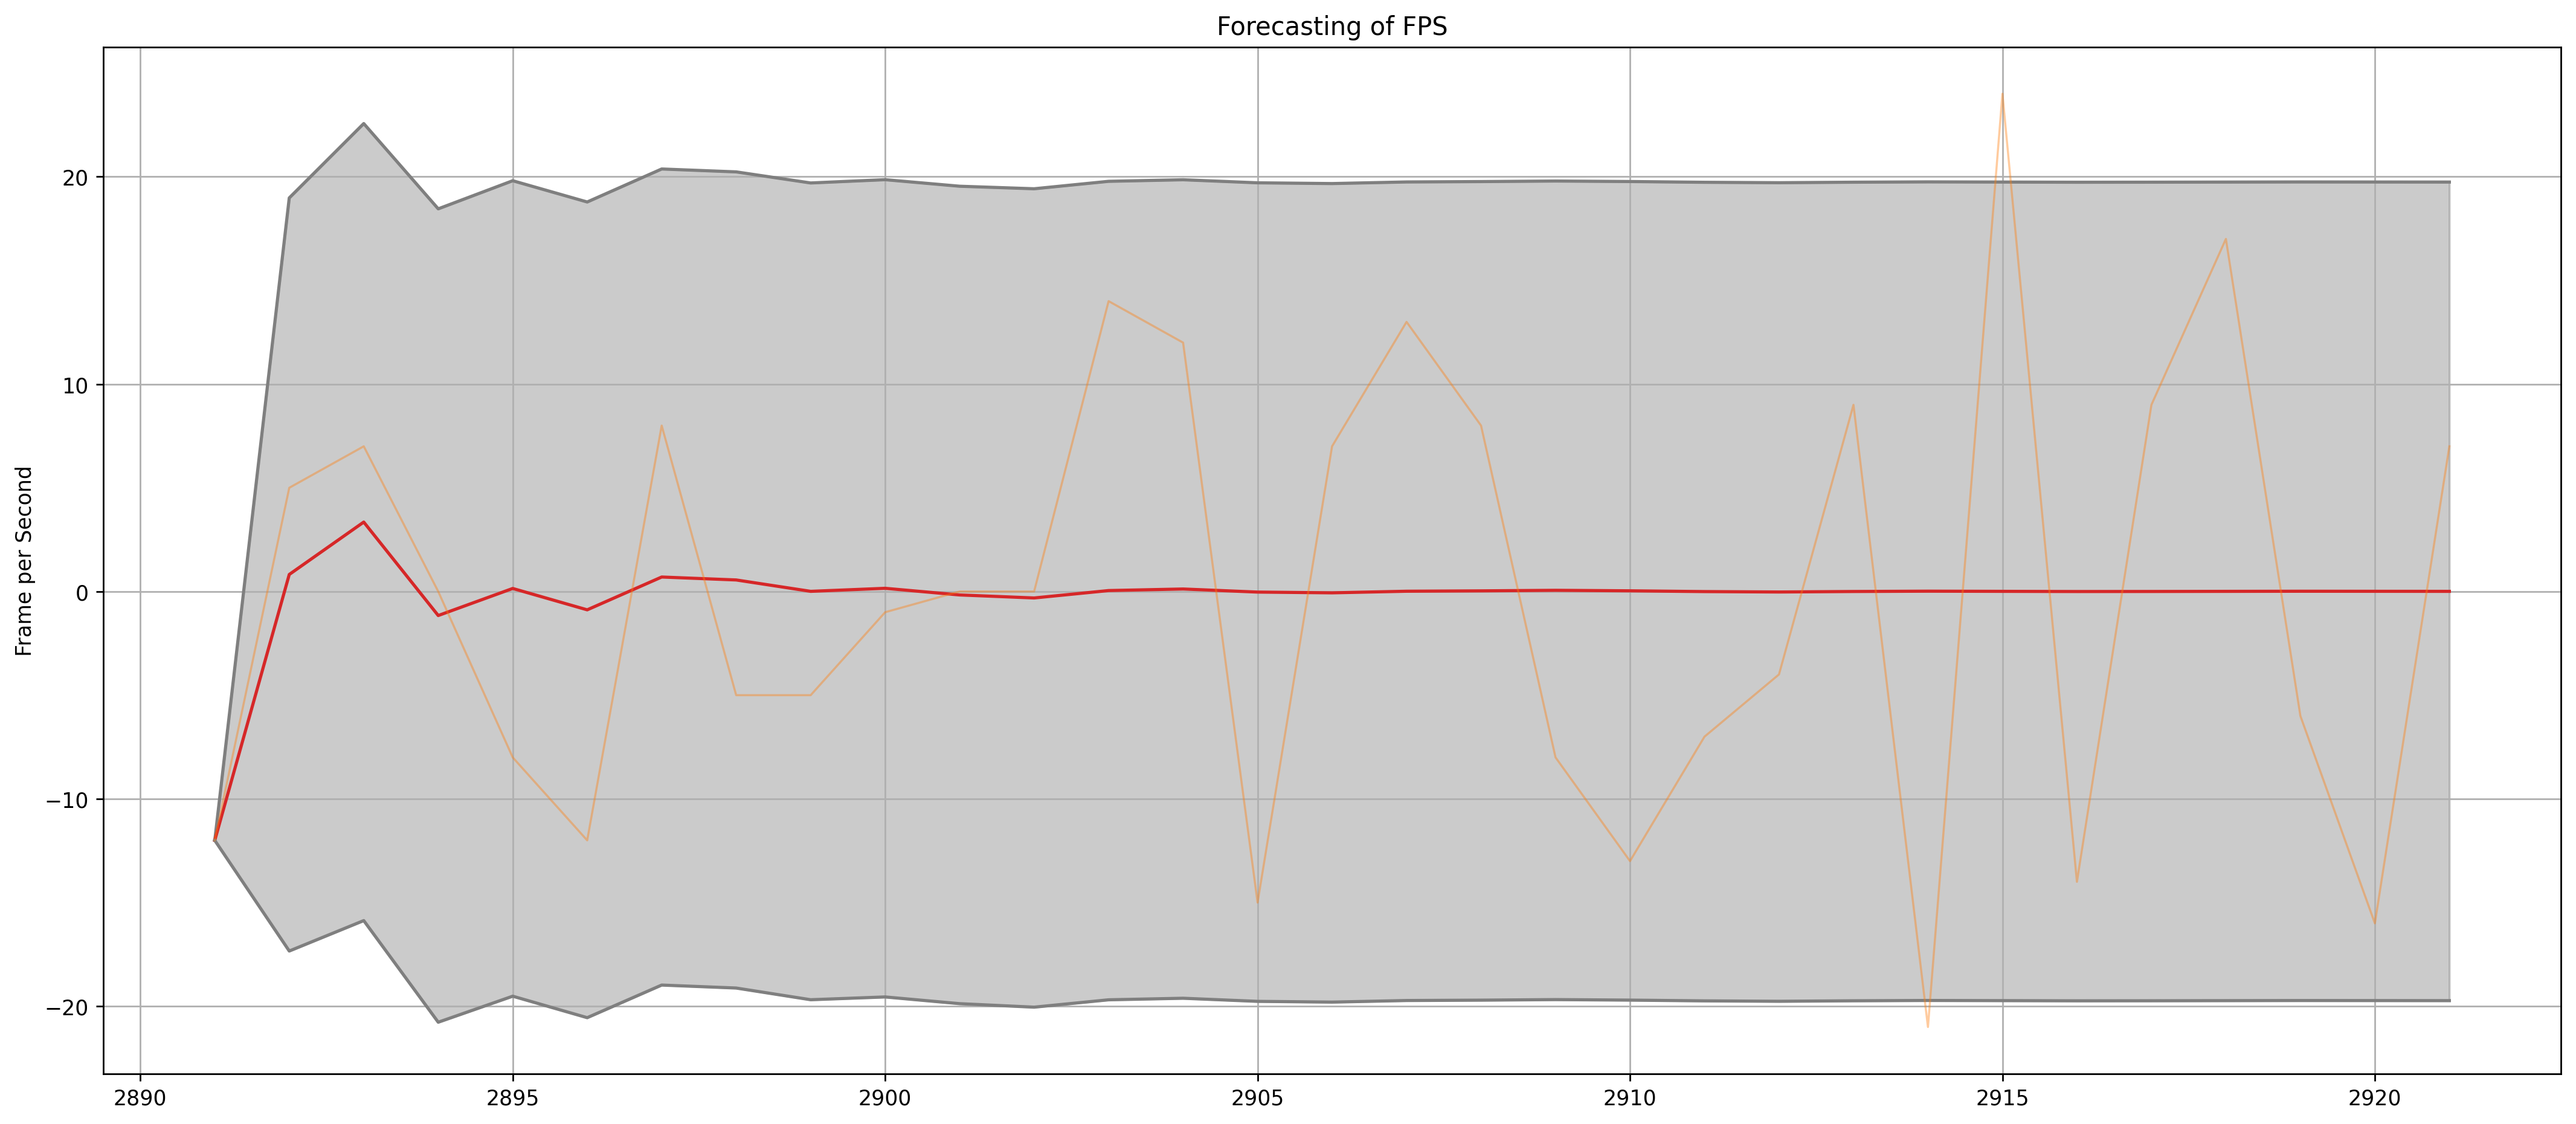

In [31]:
plt.figure(figsize=(21, 9), dpi=250)
# plt.plot(list(range(2892)), horizon_diff_train["FPS"], linewidth=1, c='tab:blue')
# plt.plot(list(range(2891, 3192)), upper:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["upper FPS"]]).iloc[2891:], c='tab:gray')
# plt.plot(list(range(2891, 3192)), pd.concat([horizon_diff_train["FPS"], varmax_forecasting.predicted_mean["FPS"]]).iloc[2891:], c='tab:red')
# plt.plot(list(range(2891, 3192)), lower:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["lower FPS"]]).iloc[2891:], c='tab:gray')
# plt.fill_between(list(range(2891, 3192)), upper, lower, color="tab:gray", alpha=0.5)
# plt.plot(list(range(2891, 3192)), horizon_diff_test["FPS"])
# plt.plot(
#     list(range(2891, 3192)), np.hstack((horizon_diff_train["FPS"].to_numpy()[-1], horizon_diff_test["FPS"].to_numpy())),
#     linewidth=1, c='tab:orange', alpha=0.4
# )
plt.plot(list(range(2891, 2922)), upper:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["upper FPS"]]).iloc[2891:2922], c='tab:gray')
plt.plot(list(range(2891, 2922)), pd.concat([horizon_diff_train["FPS"], varmax_forecasting.predicted_mean["FPS"]]).iloc[2891:2922], c='tab:red')
plt.plot(list(range(2891, 2922)), lower:=pd.concat([horizon_diff_train["FPS"], varmax_forecasting.conf_int()["lower FPS"]]).iloc[2891:2922], c='tab:gray')
plt.fill_between(list(range(2891, 2922)), upper, lower, color="tab:gray", alpha=0.4)
plt.plot(
    list(range(2891, 2922)), np.hstack((horizon_diff_train["FPS"].to_numpy()[-1], horizon_diff_test["FPS"].to_numpy()[:30])),
    linewidth=1, c='tab:orange', alpha=0.4
)
plt.title("Forecasting of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()

In [32]:
# np.save(".\\forecasting result\\var_3.npy", varmax_forecasting.predicted_mean["FPS"].to_numpy())

### Diebold-Mariano Test

In [33]:
var5_forecast = np.load(".\\forecasting result\\var_5.npy")
varma61_forecast = np.load(".\\forecasting result\\varma_61.npy")
arma103_forecast = np.load(".\\forecasting result\\arma103.npy")

In [34]:
print(
    "Diebold-Mariano Test with criterion MSE\n",
    "VARMA(6,1) with 3 variables vs. VAR(8) with 5 variables\n",
    dm_test(
        actual_lst=horizon_diff_test["FPS"].to_list(),
        pred1_lst=np.round(varma61_forecast, 4).tolist(), # VAR 3個變數預測結果
        pred2_lst=np.round(var5_forecast, 4).tolist(), # VAR 5個變數預測結果
        h=10
    ),
    sep=""
)

Diebold-Mariano Test with criterion MSE
VARMA(6,1) with 3 variables vs. VAR(8) with 5 variables
dm_return(DM=0.7620863469495835, p_value=0.4466091949610975)


In [35]:
print(
    "Diebold-Mariano Test with criterion MSE\n",
    "VARMA(6,1) with 3 variables vs. VAR(9) with 3 variables\n",
    dm_test(
        actual_lst=horizon_diff_test["FPS"].to_list(),
        pred1_lst=np.round(varma61_forecast, 4).tolist(), # VAR 3個變數預測結果
        pred2_lst=np.round(varmax_forecasting.predicted_mean["FPS"].to_numpy(), 4).tolist(), # VARMA(21) 3個變數預測結果
        h=10
    ),
    sep=""
)

Diebold-Mariano Test with criterion MSE
VARMA(6,1) with 3 variables vs. VAR(9) with 3 variables
dm_return(DM=0.9936717093878844, p_value=0.3211861796172248)


In [36]:
print(
    "Diebold-Mariano Test with criterion MSE\n",
    "VARMA(6,1) with 3 variables vs. ARMA(1,0,3)\n",
    dm_test(
        actual_lst=horizon_diff_test["FPS"].to_list(),
        pred1_lst=np.round(varma61_forecast, 4).tolist(), # VAR 3個變數預測結果
        pred2_lst=np.round(arma103_forecast, 4).tolist(), # ARMA(1,0,3) 預測結果
        h=10
    ),
    sep=""
)

Diebold-Mariano Test with criterion MSE
VARMA(6,1) with 3 variables vs. ARMA(1,0,3)
dm_return(DM=1.390658805497409, p_value=0.16536304987503422)


結論是這四個模型預測結果的精準度無顯著不同。

In [37]:
# print(
#     "Diebold-Mariano Test with criterion MSE\n",
#     "VARMA(6,1) with 3 variables vs. VAR(8) with 5 variables\n",
#     dm_test(
#         actual_lst=horizon_diff_test["FPS"].to_list(),
#         pred1_lst=np.round(varma61_forecast, 4).tolist(), # VAR 3個變數預測結果
#         pred2_lst=np.round(var5_forecast, 4).tolist(), # VAR 5個變數預測結果
#         h=10
#     ),
#     "\n",
#     sep=""
# )
# print(
#     "VARMA(6,1) with 3 variables vs. VAR(9) with 3 variables\n",
#     dm_test(
#         actual_lst=horizon_diff_test["FPS"].to_list(),
#         pred1_lst=np.round(varma61_forecast, 4).tolist(), # VAR 3個變數預測結果
#         pred2_lst=np.round(varmax_forecasting.predicted_mean["FPS"].to_numpy(), 4).tolist(), # VARMA(21) 3個變數預測結果
#         h=10
#     ),
#     "\n",
#     sep=""
# )
# print(
#     "VARMA(6,1) with 3 variables vs. ARMA(1,0,3)\n",
#     dm_test(
#         actual_lst=horizon_diff_test["FPS"].to_list(),
#         pred1_lst=np.round(varma61_forecast, 4).tolist(), # VAR 3個變數預測結果
#         pred2_lst=np.round(arma103_forecast, 4).tolist(), # ARMA(1,0,3) 預測結果
#         h=10
#     ),
#     "\n",
#     sep=""
# )

## VAR

In [38]:
horizon_train = horizon[:-10] # (3183, 3)
horizon_test = horizon[-10:] # (10, 3)
fps = horizon["FPS"].to_numpy()

In [39]:
var_re = VAR(horizon_train)
var_order_result_re = var_re.select_order(12)
var_order_result_re.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [40]:
ic_table_re = pd.read_html(var_order_result_re.summary().as_html(), header=0, index_col=0)

In [41]:
ic_table_re[0] = ic_table_re[0].replace("\*$", "", regex=True)
ic_table_re[0] = ic_table_re[0].astype("float64")

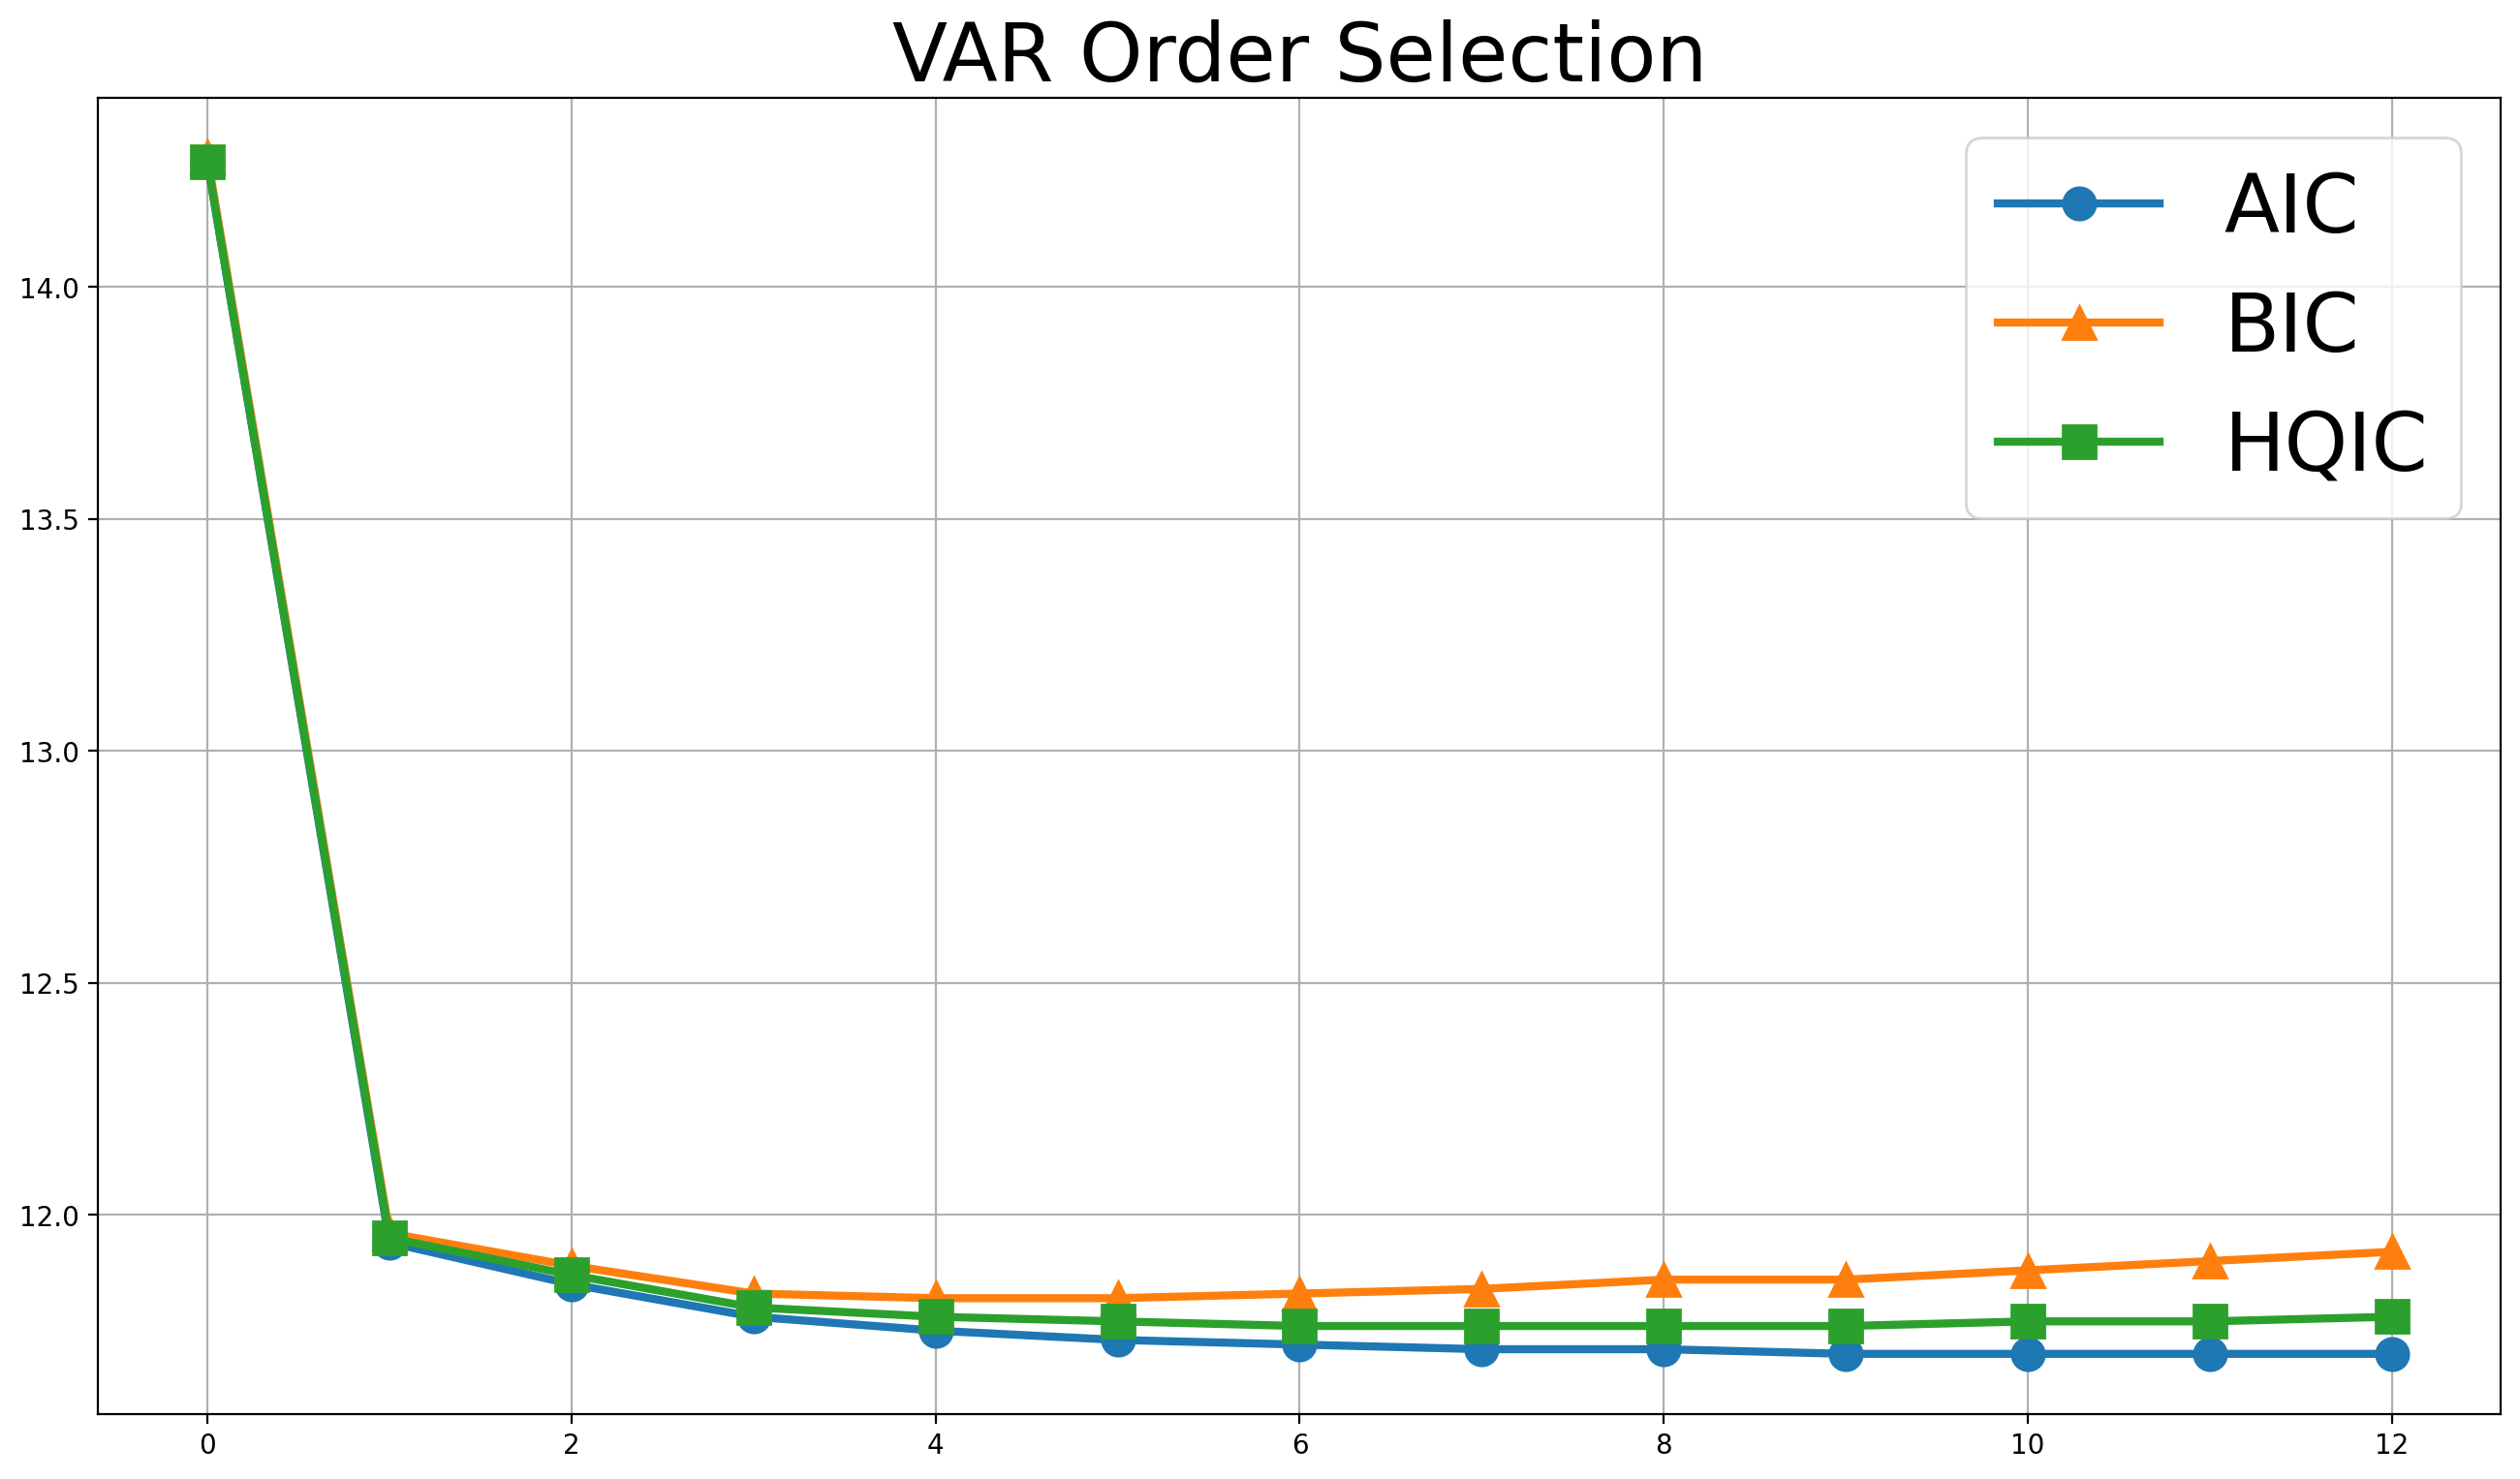

In [42]:
plt.figure(figsize=(16,9), dpi=200)
aic, = plt.plot(ic_table_re[0]["AIC"], "-o", linewidth=3, ms=12, label="AIC")
bic, = plt.plot(ic_table_re[0]["BIC"], "-^", linewidth=3, ms=12, label="BIC")
hqic, = plt.plot(ic_table_re[0]["HQIC"], "-s", linewidth=3, ms=12, label="HQIC")
plt.legend(handles=[aic, bic, hqic], fontsize=30)
plt.title("VAR Order Selection", fontdict={'fontsize':30})
plt.grid()
plt.show()

In [43]:
var_result_re = var.fit(4)
print("llf: ", var_result_re.llf)
print(var_result_re.info_criteria)

llf:  -29035.585371239027
{'aic': 11.621123212987357, 'bic': 11.701720325349024, 'hqic': 11.650169938110272, 'fpe': 111426.82711679707}


In [44]:
var_result_re.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Jun, 2022
Time:                     23:33:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.7017
Nobs:                     2888.00    HQIC:                   11.6502
Log likelihood:          -29035.6    FPE:                    111427.
AIC:                      11.6211    Det(Omega_mle):         109936.
--------------------------------------------------------------------
Results for equation CPU Overall Power Consumption
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                    0.021268         0.059351            0.358           0.720
L1.CPU Overall Power Consumption        -0.396399         0.

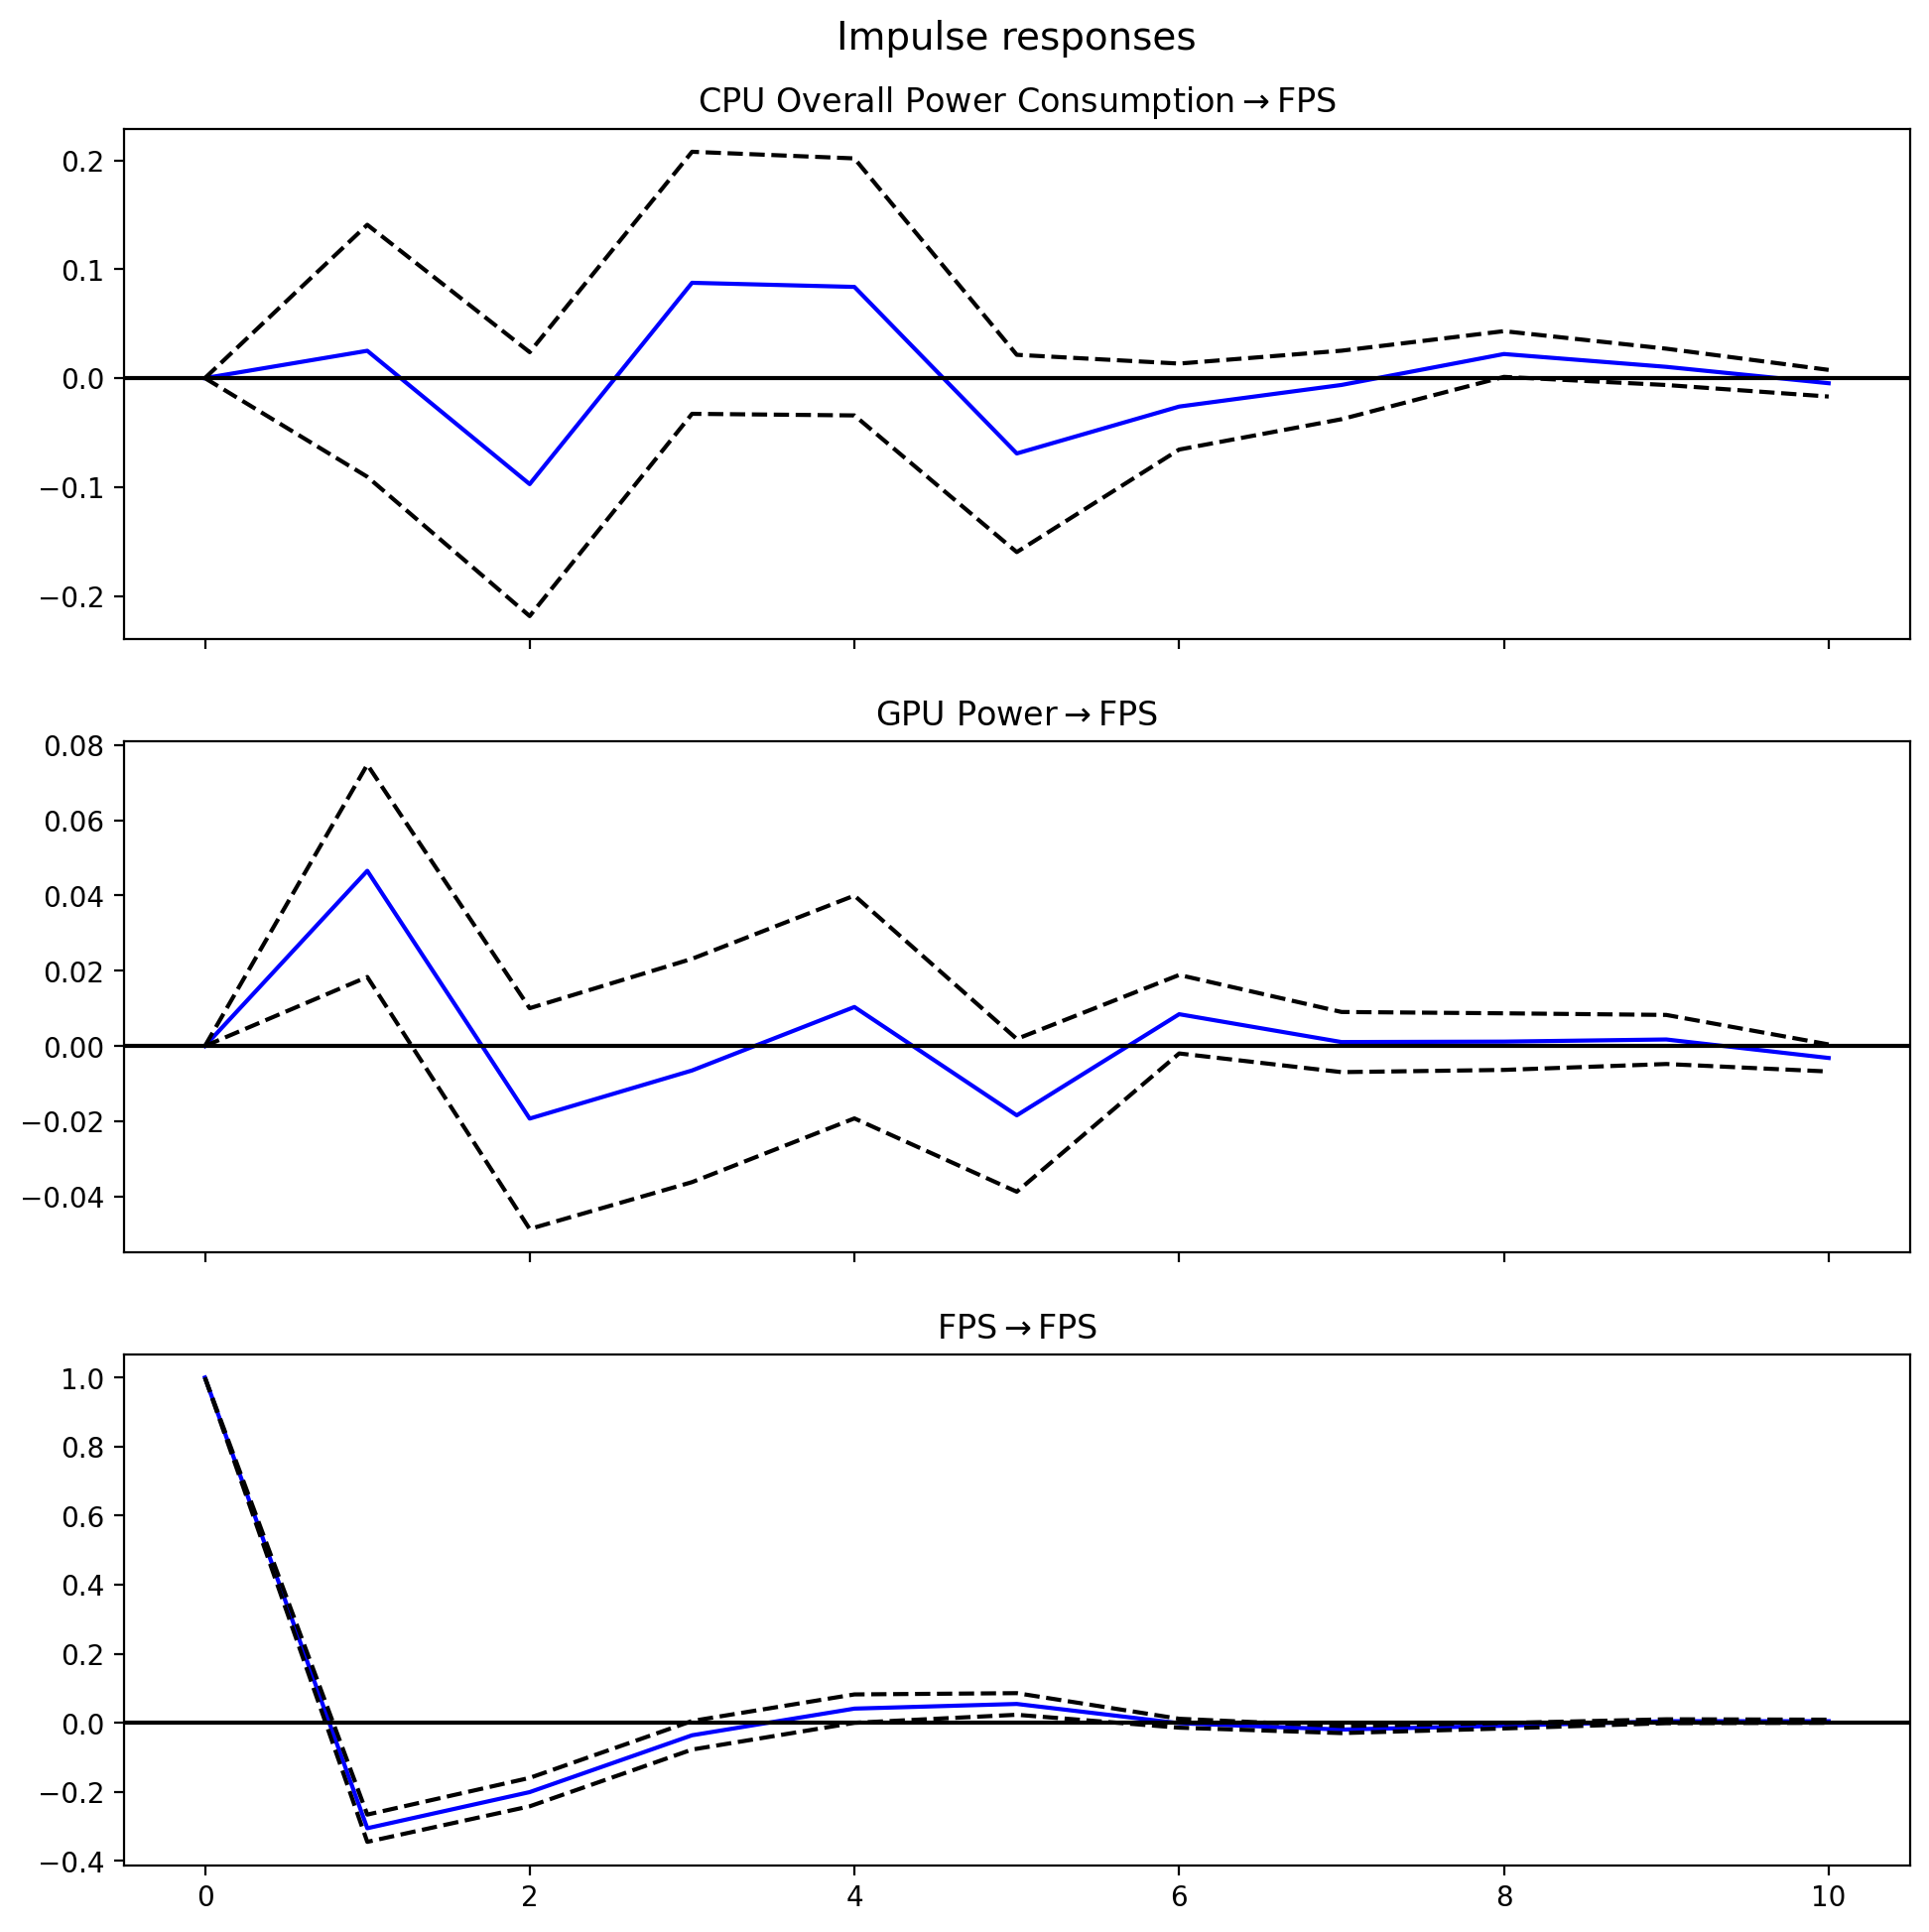

In [45]:
irf_var_re = var_result_re.irf()
irf_var_re.plot(response="FPS")
plt.show()

In [46]:
var_result_re.test_whiteness().summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [47]:
var_result_re.test_normality().summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [48]:
var_result_re.test_causality(
    "FPS",
    ["CPU Overall Power Consumption", "GPU Power"],
    kind='f'
).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

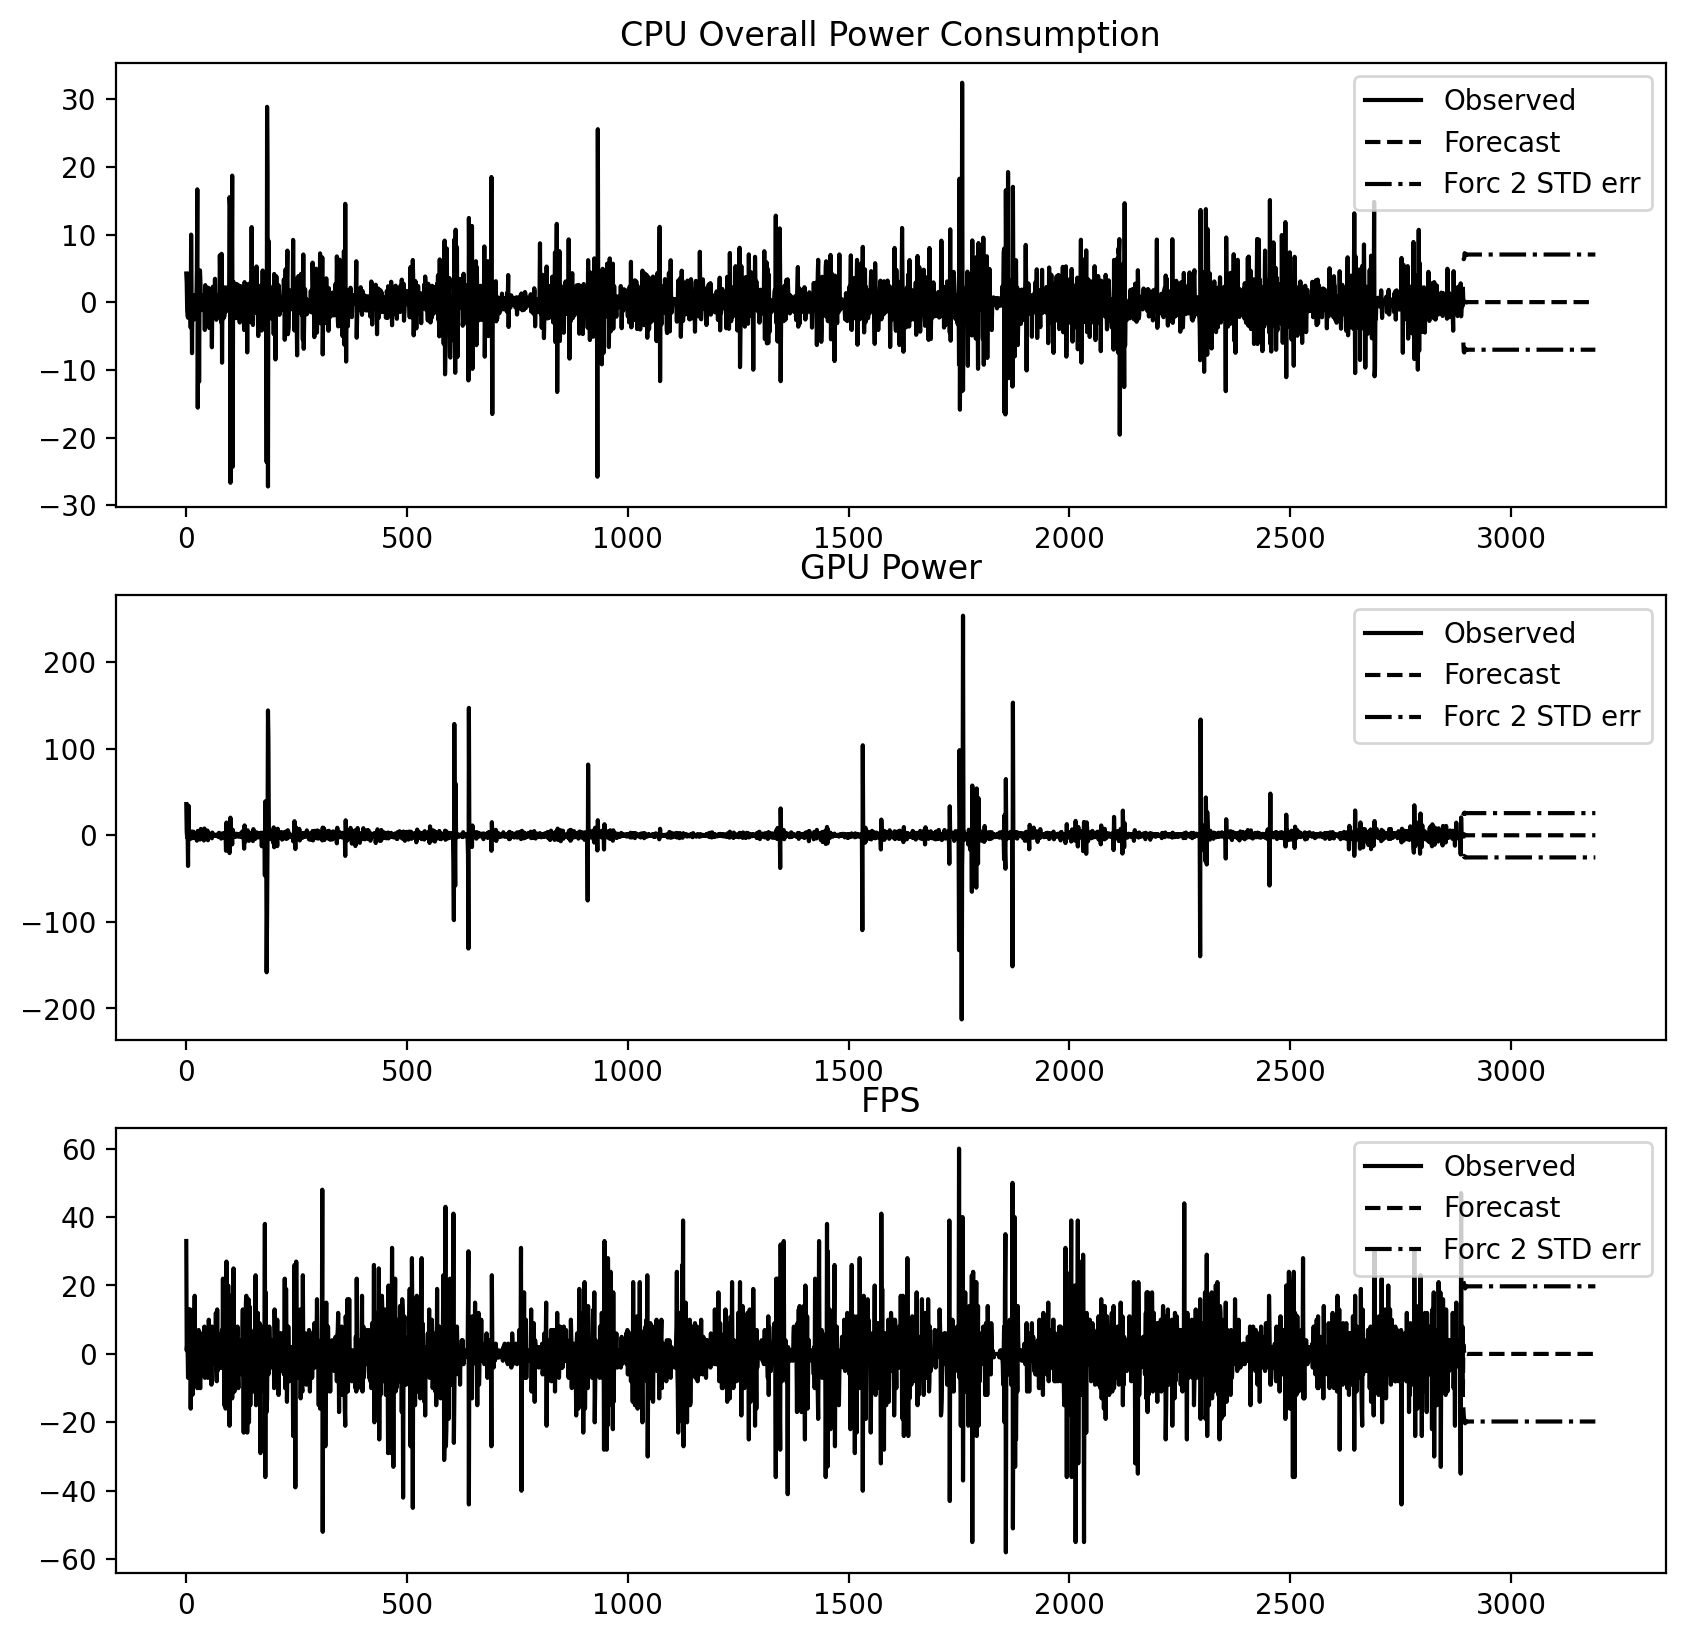

In [49]:
fig_re = var_result_re.plot_forecast(steps=300)
fig_re.dpi = 200
plt.show()

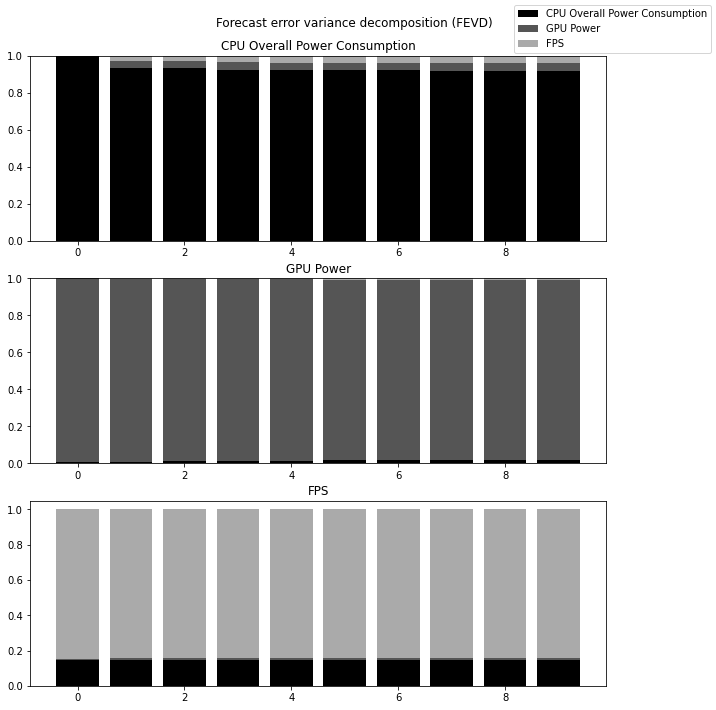

In [50]:
fevd_re = var_result_re.fevd()
fevd_re.plot()
plt.show()

In [51]:
var_result_re.resid_acorr(nlags=0).reshape((3,3))

array([[ 1.        ,  0.08379942, -0.38342162],
       [ 0.08379942,  1.        , -0.10589635],
       [-0.38342162, -0.10589635,  1.        ]])

### VARMAX

In [52]:
# model_result40 = VARMAX(horizon_train, order=(4, 0)).fit()
# model_result40.save(f".\\weights\\VAR 3\\VAR_result_40.pickle")

In [53]:
varmax_result = load_pickle(".\\weights\\VAR 3\\VAR_result_40.pickle")

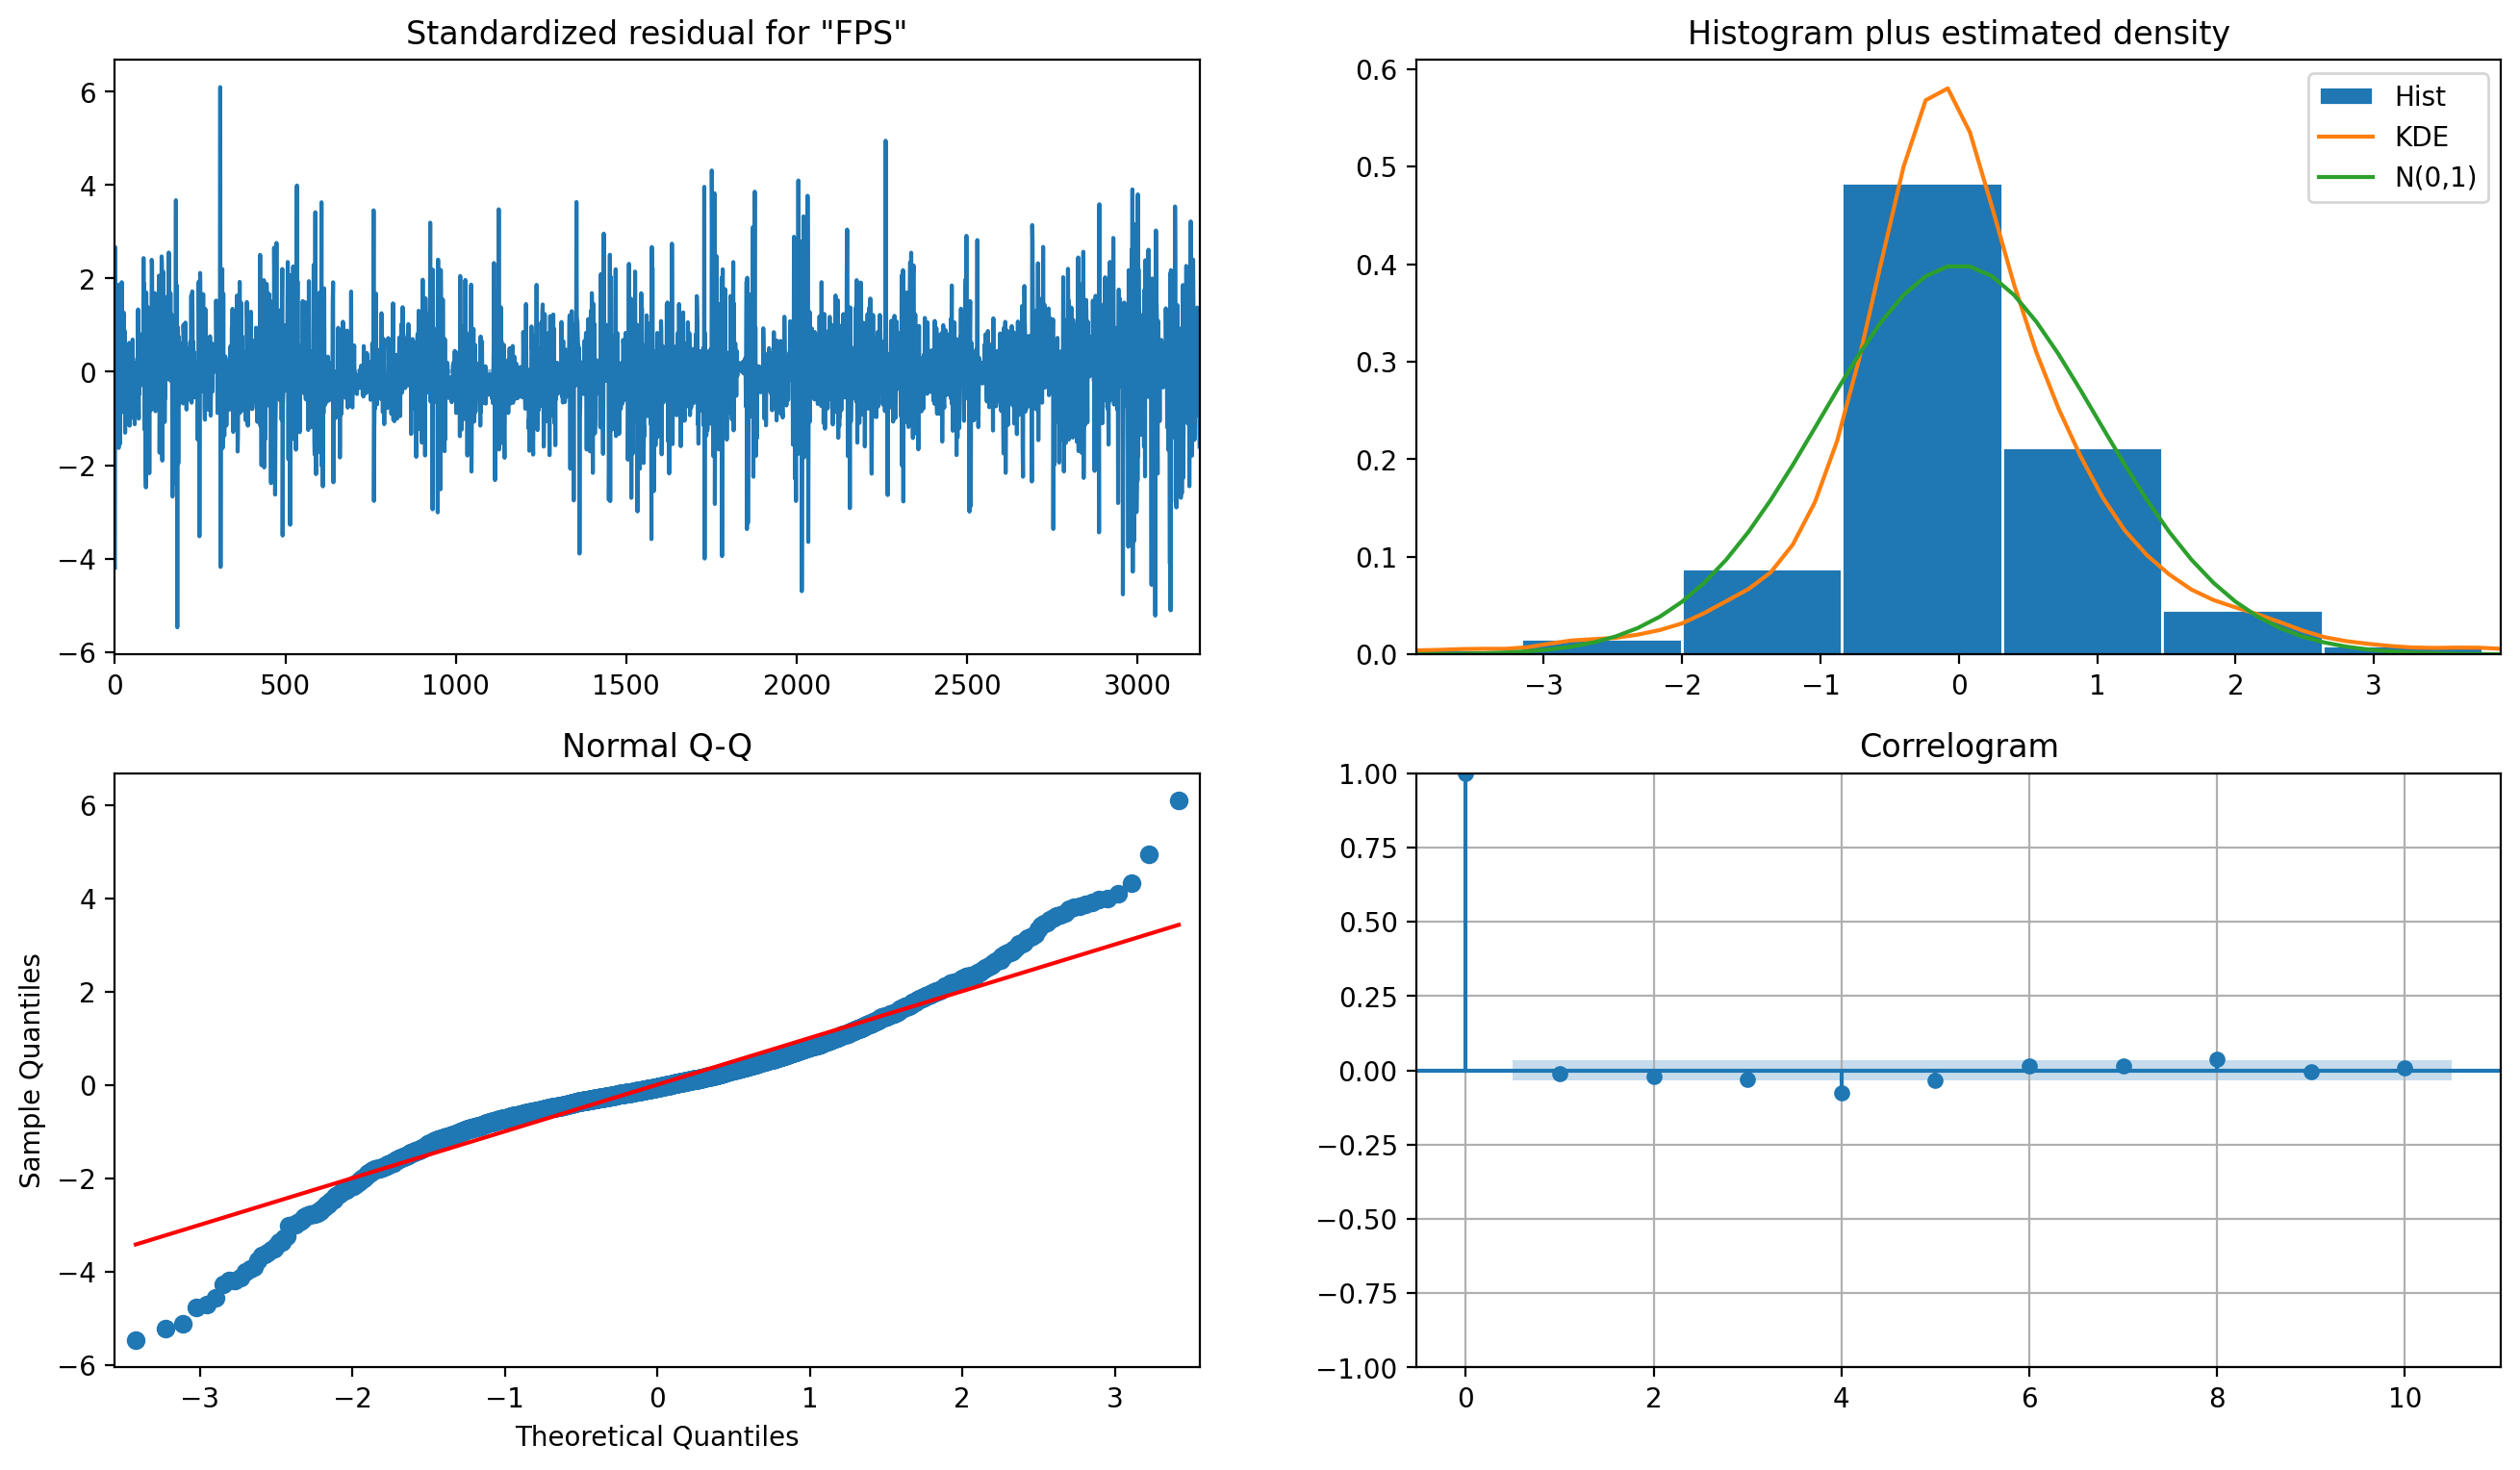

In [54]:
varmax_result.plot_diagnostics(variable=2, fig=plt.figure(figsize=(16,9), dpi=200))
plt.grid()
plt.show()

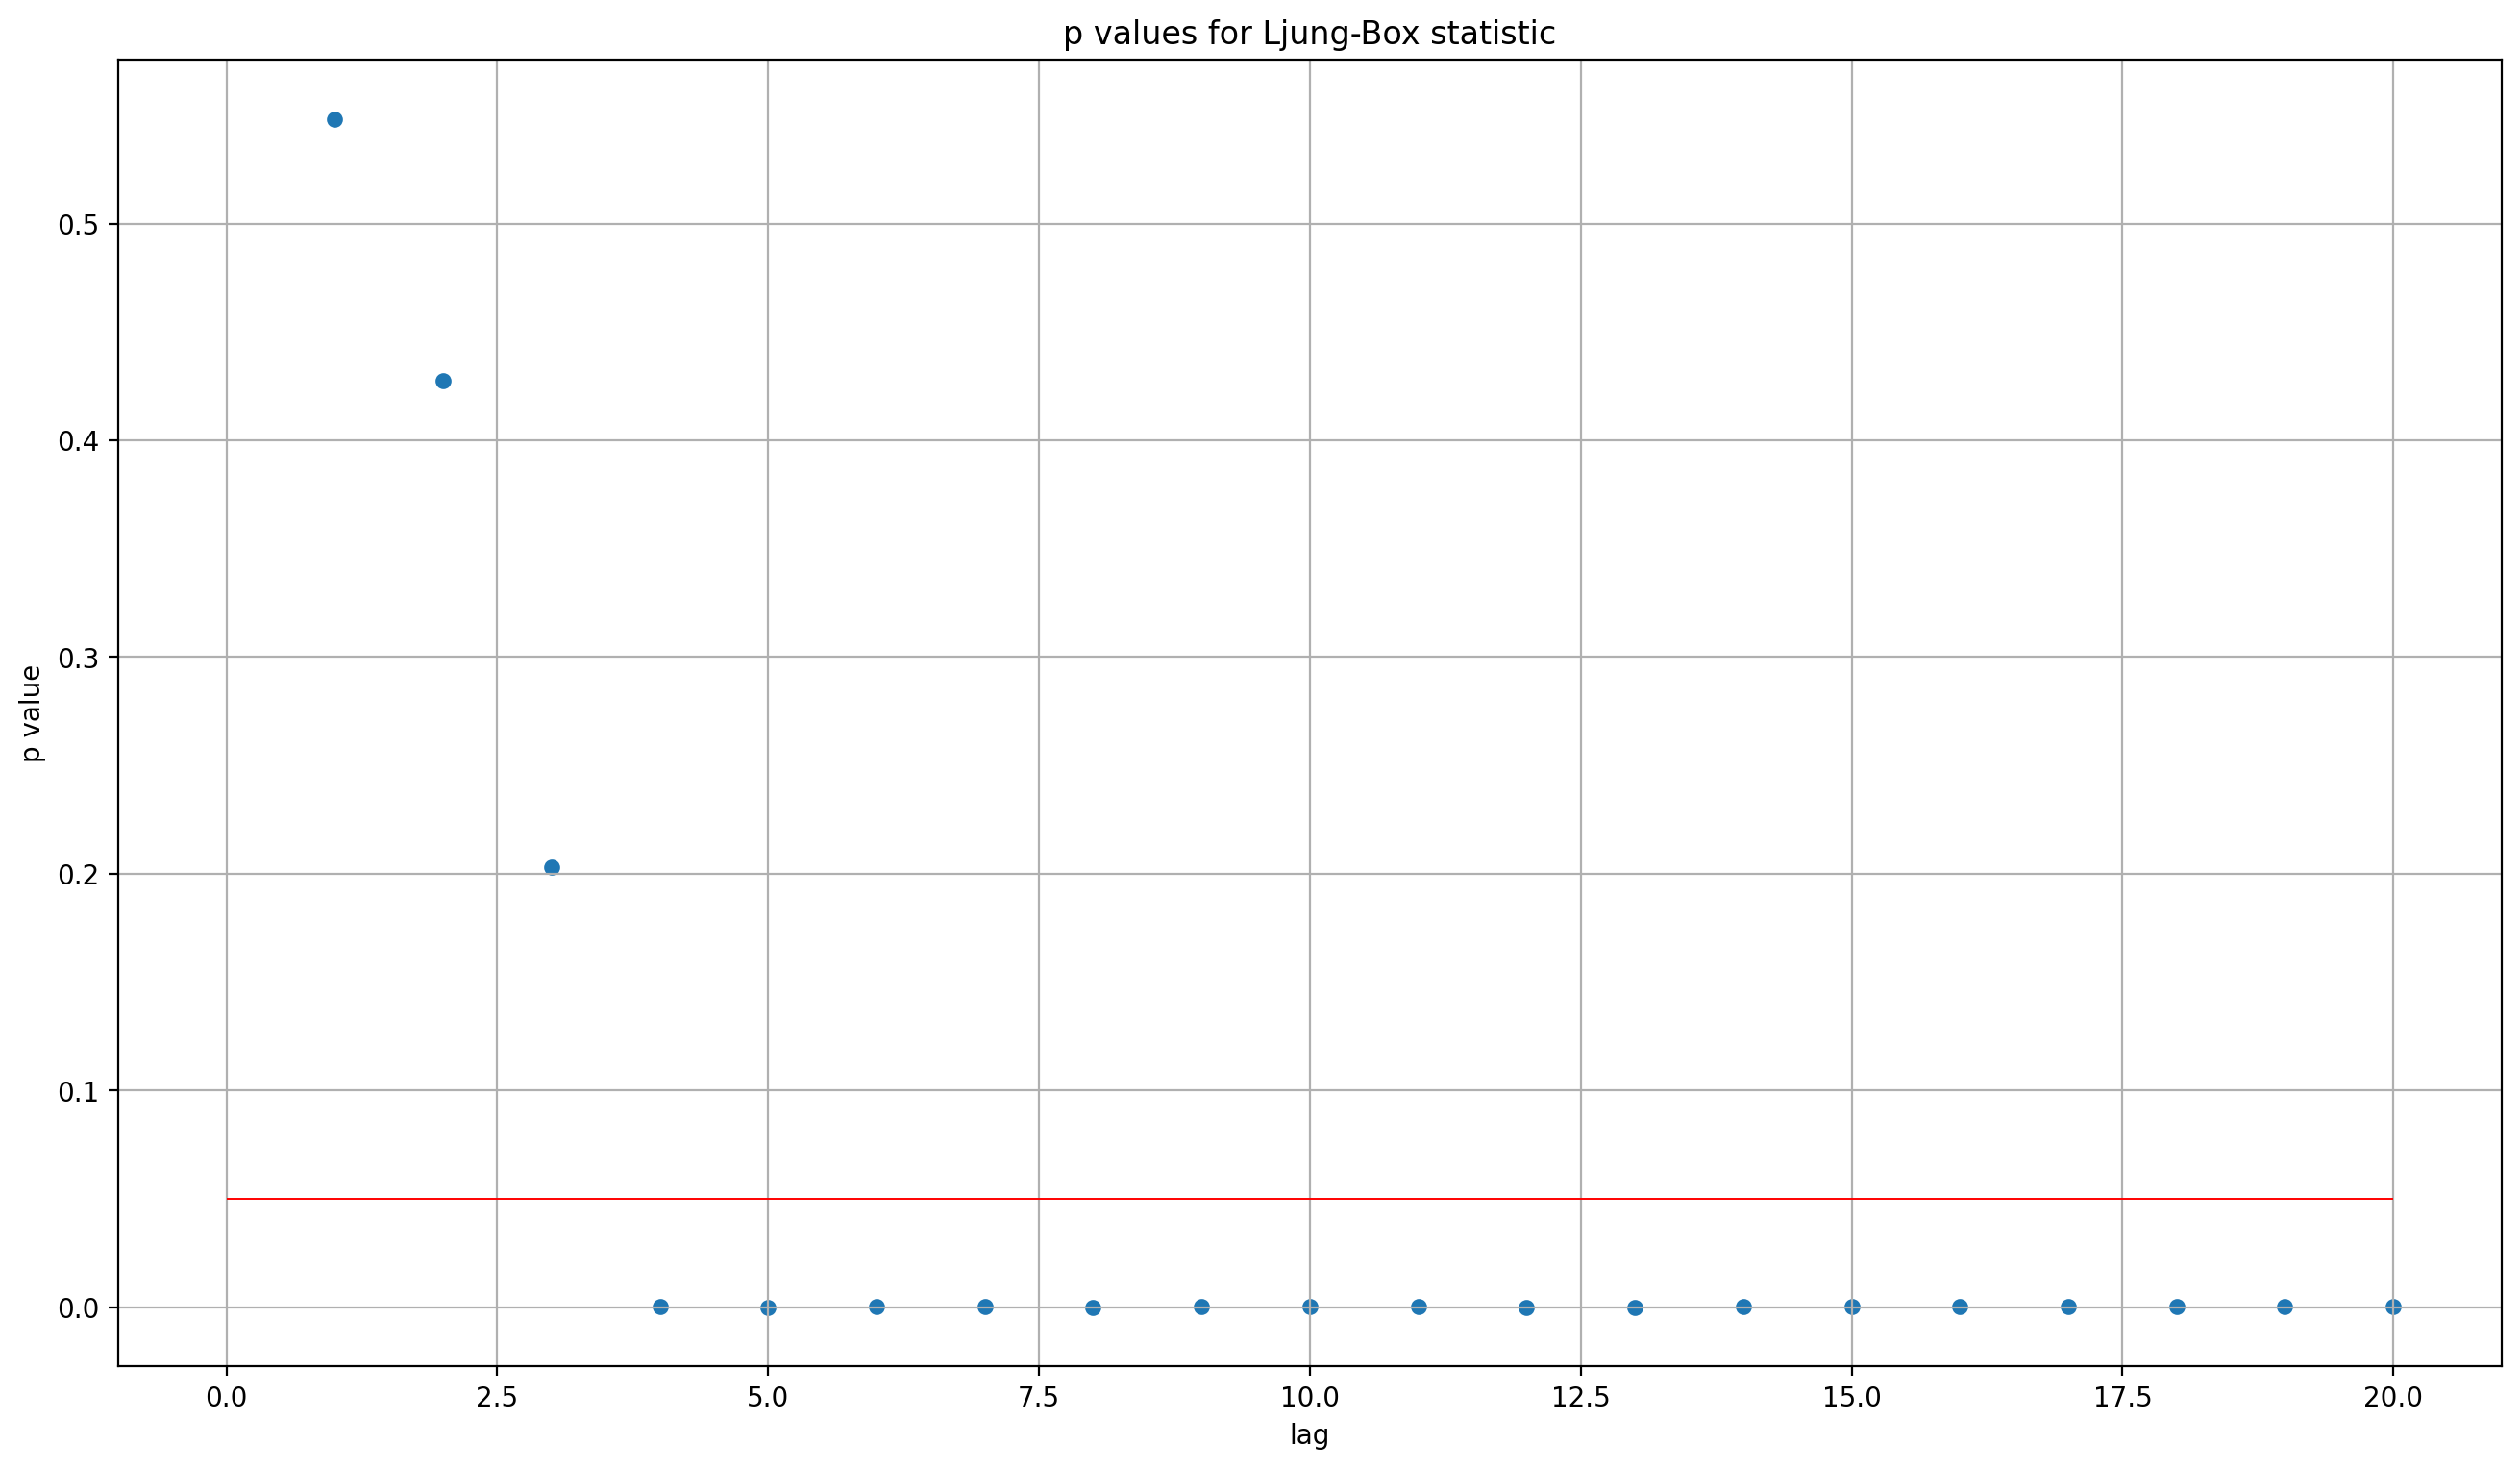

In [55]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(list(range(1,21)), varmax_result.test_serial_correlation(method="ljungbox", lags=20)[2, 1, :], s=25)
plt.hlines(y=[0.05], xmin=0, xmax=20, colors="r", linewidths=0.7)
plt.title("p values for Ljung-Box statistic")
plt.xlabel("lag")
plt.ylabel("p value")
plt.grid()
plt.show()

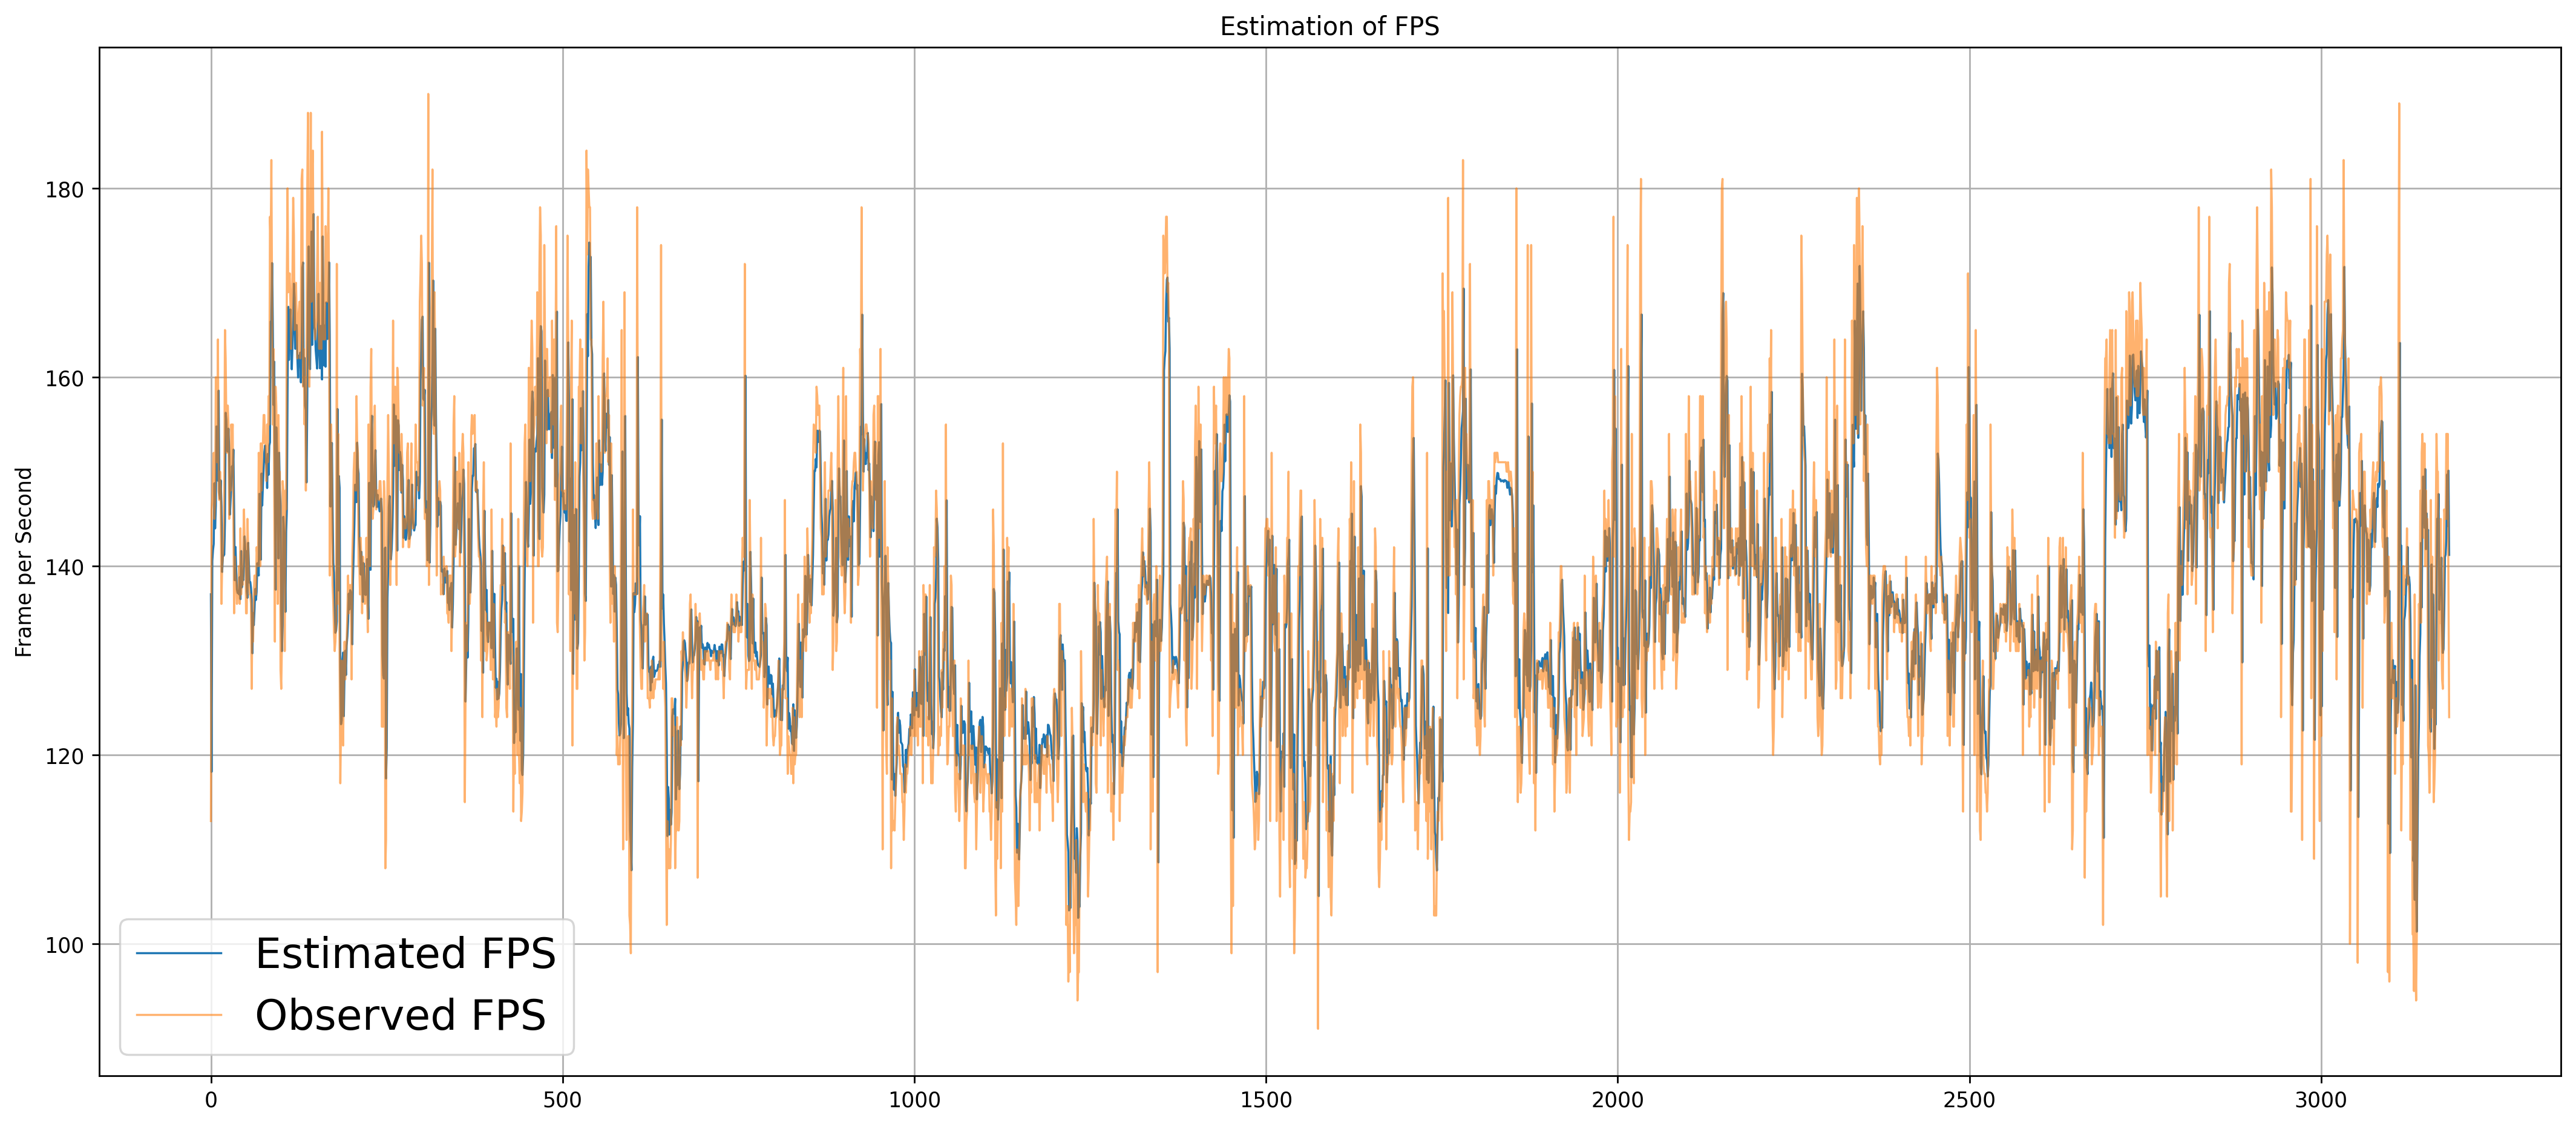

In [59]:
hat_FPS = varmax_result.predict().to_numpy()[:, 2]
plt.figure(figsize=(21, 9), dpi=250)
ts1, = plt.plot(hat_FPS, linewidth=1, label="Estimated FPS", c='tab:blue')
ts2, = plt.plot(horizon_train["FPS"], linewidth=1, label="Observed FPS", c='tab:orange', alpha=0.6)
plt.legend(handles=[ts1, ts2], fontsize=20)
plt.title("Estimation of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()

In [57]:
varmax_forecasting_re = varmax_result.get_forecast(steps=300)

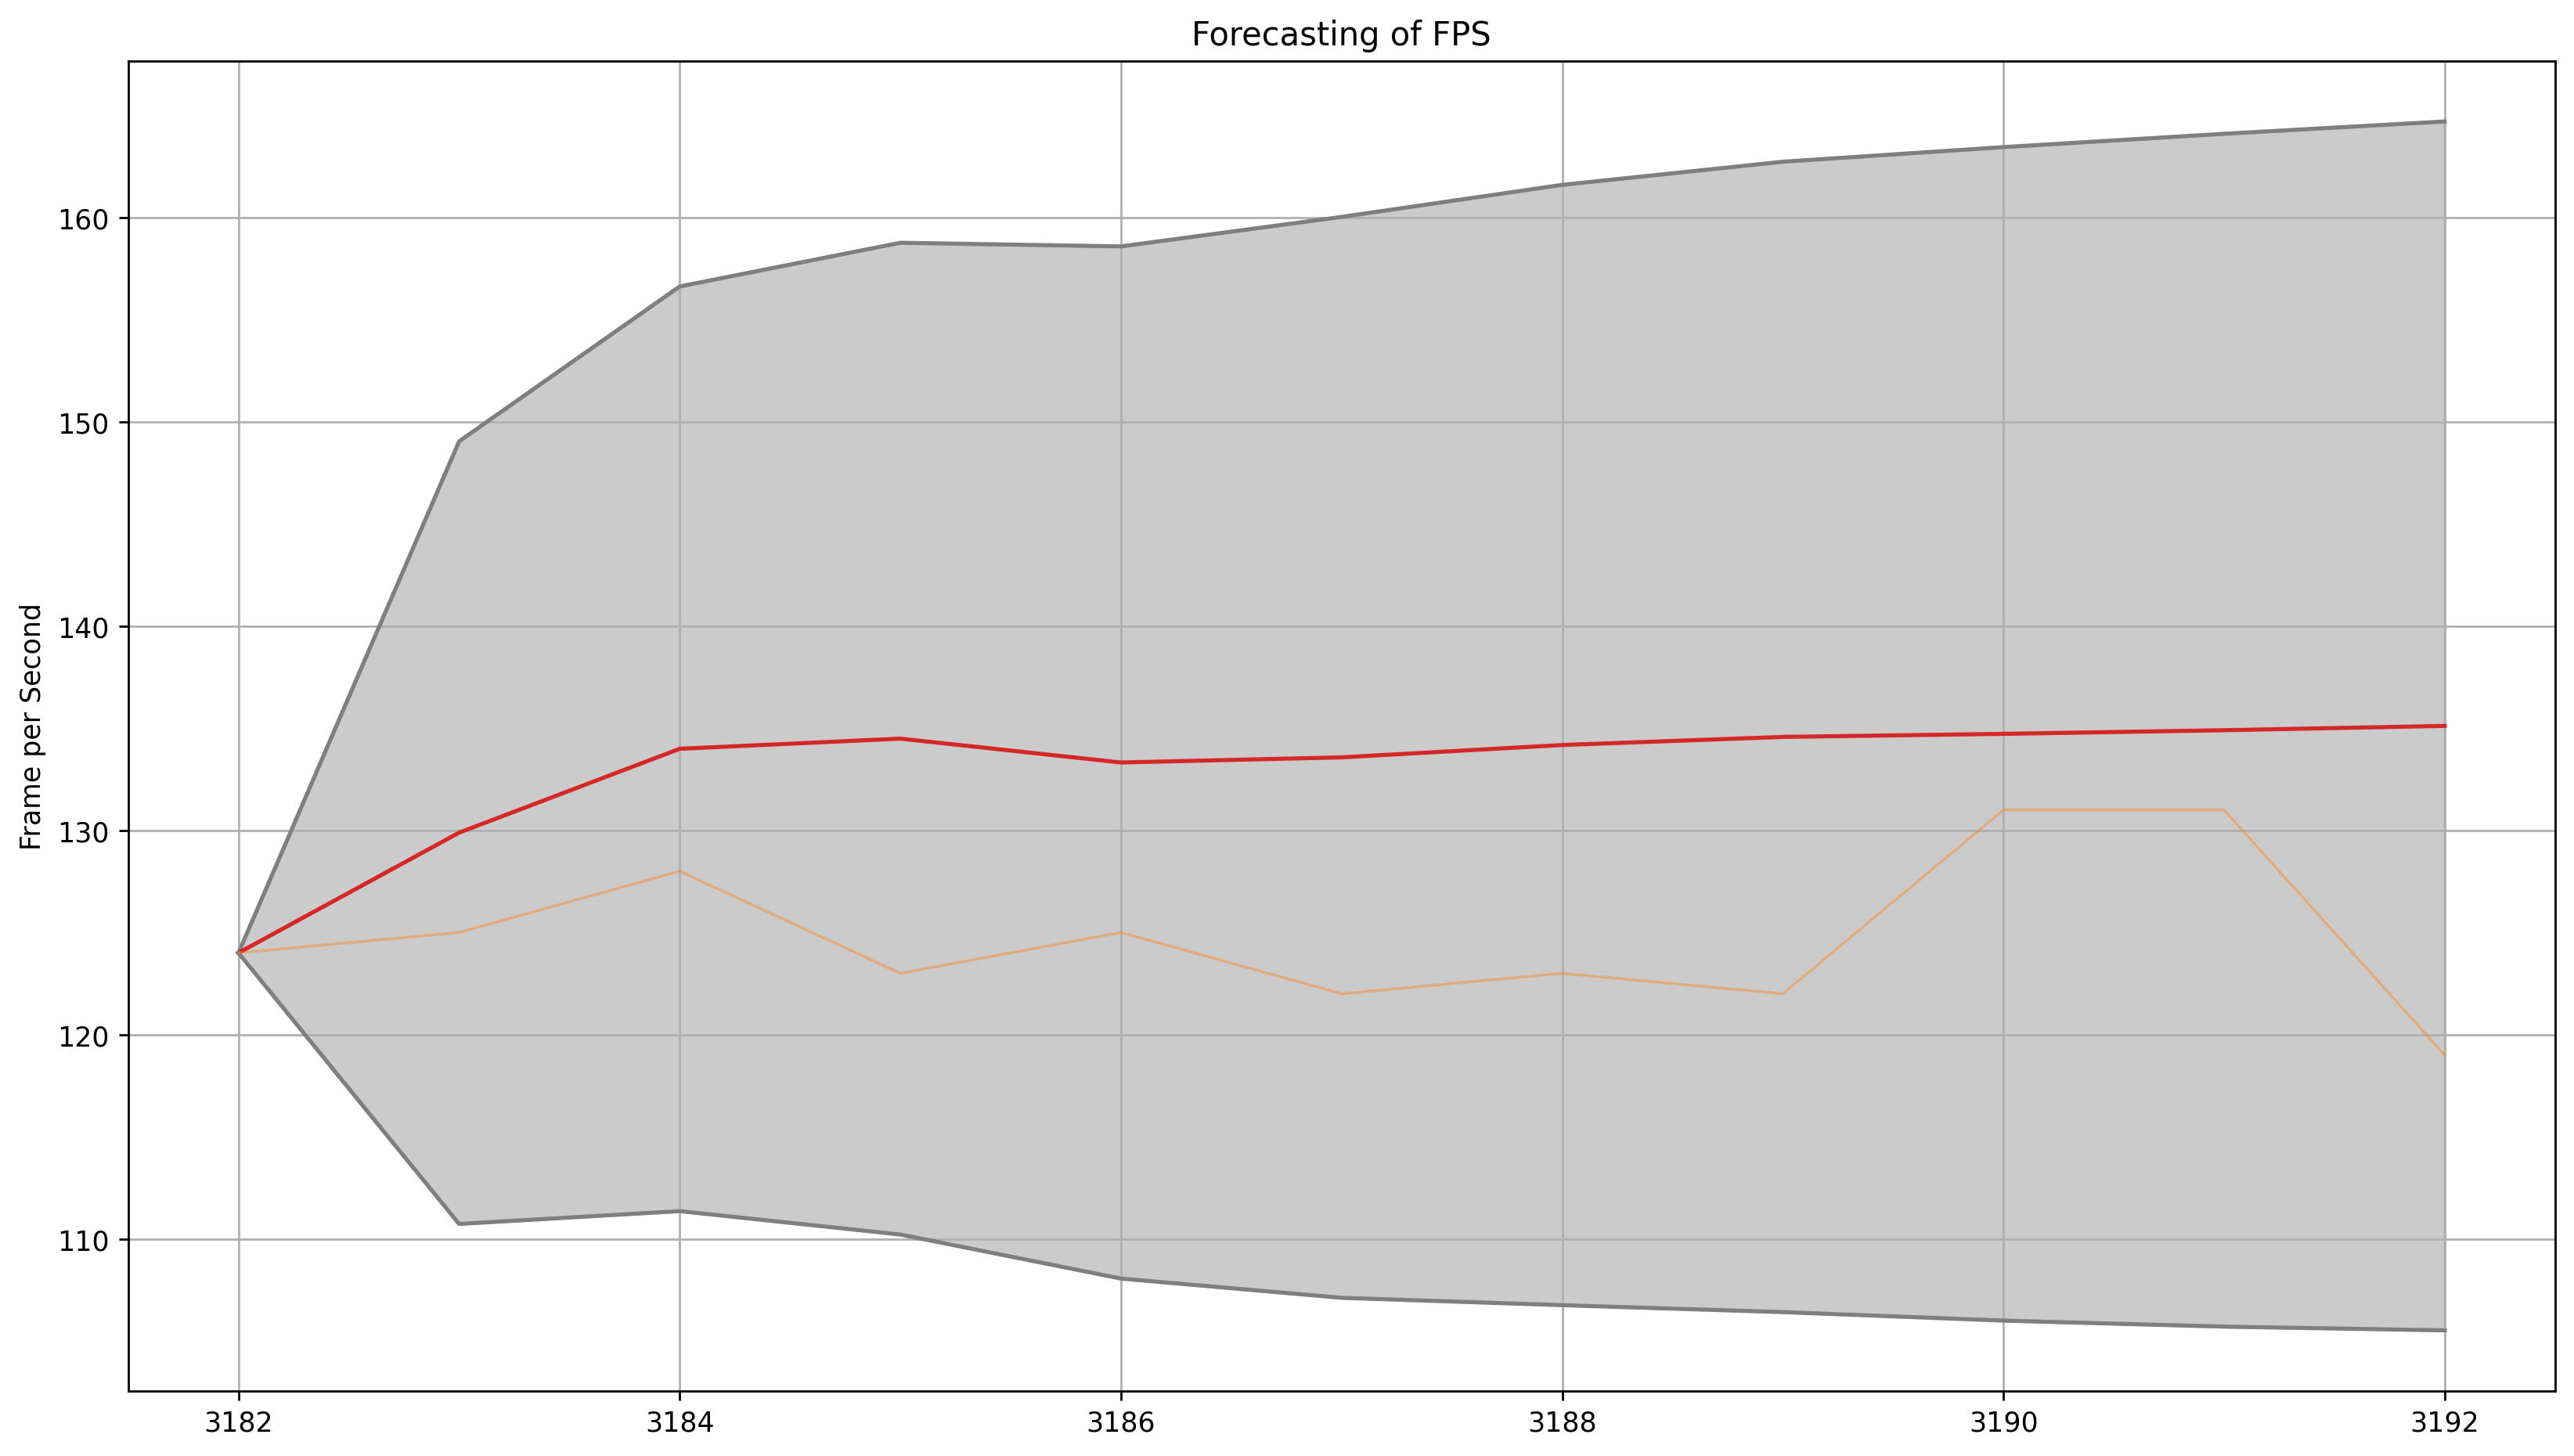

In [58]:
plt.figure(figsize=(16, 9), dpi=250)
plt.plot(list(range(3182, 3193)), upper:=pd.concat([horizon_train["FPS"], varmax_forecasting_re.conf_int()["upper FPS"]]).iloc[3182:3193], c='tab:gray')
plt.plot(list(range(3182, 3193)), pd.concat([horizon_train["FPS"], varmax_forecasting_re.predicted_mean["FPS"]]).iloc[3182:3193], c='tab:red')
plt.plot(list(range(3182, 3193)), lower:=pd.concat([horizon_train["FPS"], varmax_forecasting_re.conf_int()["lower FPS"]]).iloc[3182:3193], c='tab:gray')
plt.fill_between(list(range(3182, 3193)), upper, lower, color="tab:gray", alpha=0.4)
plt.plot(
    list(range(3182, 3193)), np.hstack((horizon_train["FPS"].to_numpy()[-1], horizon_test["FPS"].to_numpy())),
    linewidth=1, c='tab:orange', alpha=0.4
)
plt.title("Forecasting of FPS")
plt.ylabel("Frame per Second")
plt.grid()
plt.show()